In [1]:
import pandas as pd
import numpy as np
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Flatten, ConvLSTM2D, Dropout
import tensorflow.keras.backend as K

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [49]:
n_steps = 8 # we use 12h window
n_lookup = 4 # predict series of 4 values in time t1, t2, t3, t4

In [50]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_sub = pd.read_csv("sample_submission.csv")

print(df_test.shape)
print(df_sub.shape)

features = ['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
targets_values = np.log1p(df_train[targets]).values


df_test = pd.concat([df_train[len(df_train)-n_steps-1:len(df_train)-1].drop(targets , axis = 1), df_test])

df_all = pd.concat([df_train.drop(targets , axis = 1), df_test])

df_all['date_time'] = pd.to_datetime(df_all['date_time'])


df_train.set_index('date_time', inplace=True)
df_test.set_index('date_time', inplace=True)
print(df_test.shape)
print(df_all.shape)

(2247, 9)
(2247, 4)
(2255, 8)
(9366, 9)


In [4]:
df_train

deg_C  relative_humidity  absolute_humidity  sensor_1  \
date_time                                                                    
2010-03-10 18:00:00   13.1               46.0             0.7578    1387.2   
2010-03-10 19:00:00   13.2               45.3             0.7255    1279.1   
2010-03-10 20:00:00   12.6               56.2             0.7502    1331.9   
2010-03-10 21:00:00   11.0               62.4             0.7867    1321.0   
2010-03-10 22:00:00   11.9               59.0             0.7888    1272.0   
...                    ...                ...                ...       ...   
2010-12-31 20:00:00    9.2               32.0             0.3871    1000.5   
2010-12-31 21:00:00    9.1               33.2             0.3766    1022.7   
2010-12-31 22:00:00    9.6               34.6             0.4310    1044.4   
2010-12-31 23:00:00    8.0               40.7             0.4085     952.8   
2011-01-01 00:00:00    8.0               41.3             0.4375    1108.8   

                     sensor_2  sensor_3  sensor_4  sensor_5  \
date_time                                                     
2010-03-10 18:00:00    1087.8    1056.0    1742.8    1293.4   
2010-03-10 19:00:00     888.2    1197.5    1449.9    1010.9   
2010-03-10 20:00:00     929.6    1060.2    1586.1    1117.0   
2010-03-10 21:00:00     929.0    1102.9    1536.5    1263.2   
2010-03-10 22:00:00     852.7    1180.9    1415.5    1132.2   
...                       ...       ...       ...       ...   
2010-12-31 20:00:00     811.2     873.0     909.0     910.5   
2010-12-31 21:00:00     790.0     951.6     912.9     903.4   
2010-12-31 22:00:00     767.3     861.9     889.2    1159.1   
2010-12-31 23:00:00     691.9     908.5     917.0    1206.3   
2011-01-01 00:00:00     745.7     797.1     880.0    1273.1   

                     target_carbon_monoxide  target_benzene  \
date_time                                                     
2010-03-10 18:00:00                     2.5            12.0   
2010-03-10 19:00:00                     2.1             9.9   
2010-03-10 20:00:00                     2.2             9.2   
2010-03-10 21:00:00                     2.2             9.7   
2010-03-10 22:00:00                     1.5             6.4   
...                                     ...             ...   
2010-12-31 20:00:00                     1.3             5.1   
2010-12-31 21:00:00                     1.4             5.8   
2010-12-31 22:00:00                     1.6             5.2   
2010-12-31 23:00:00                     1.5             4.6   
2011-01-01 00:00:00                     1.4             4.1   

                     target_nitrogen_oxides  
date_time                                    
2010-03-10 18:00:00                   167.7  
2010-03-10 19:00:00                    98.9  
2010-03-10 20:00:00                   127.1  
2010-03-10 21:00:00                   177.2  
2010-03-10 22:00:00                   121.8  
...                                     ...  
2010-12-31 20:00:00                   191.1  
2010-12-31 21:00:00                   221.3  
2010-12-31 22:00:00                   227.4  
2010-12-31 23:00:00                   199.8  
2011-01-01 00:00:00                   186.5  

[7111 rows x 11 columns]

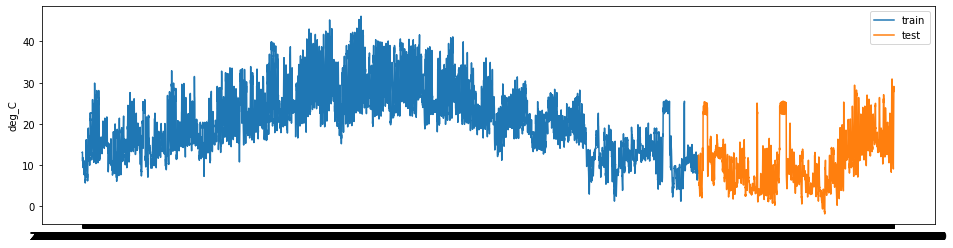

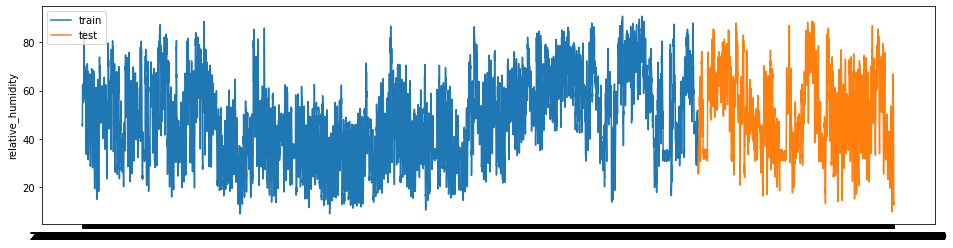

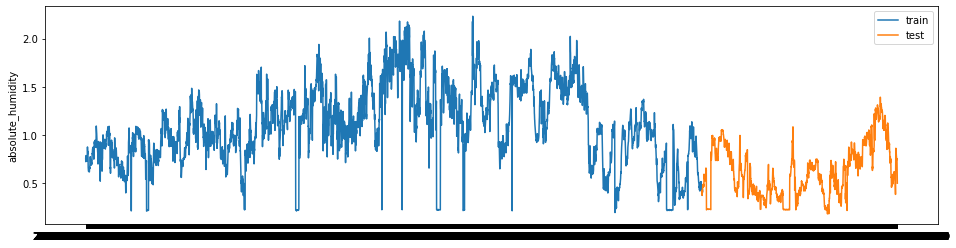

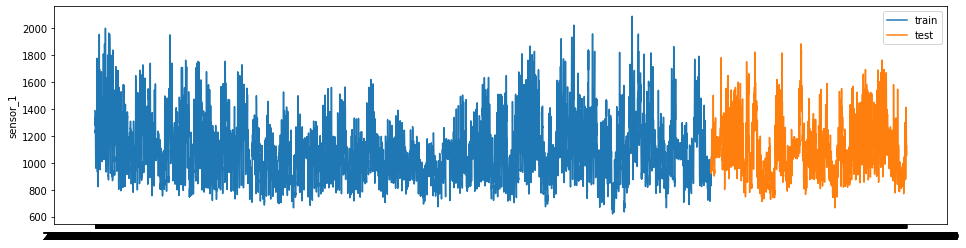

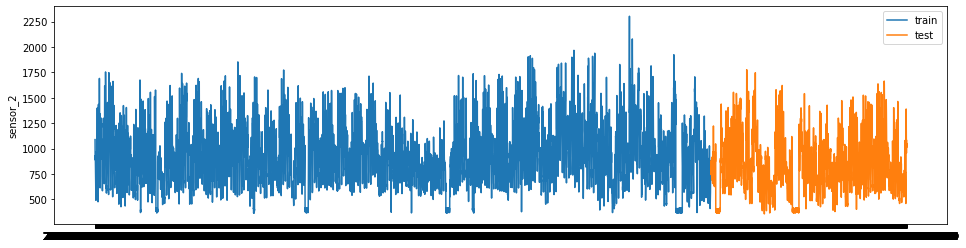

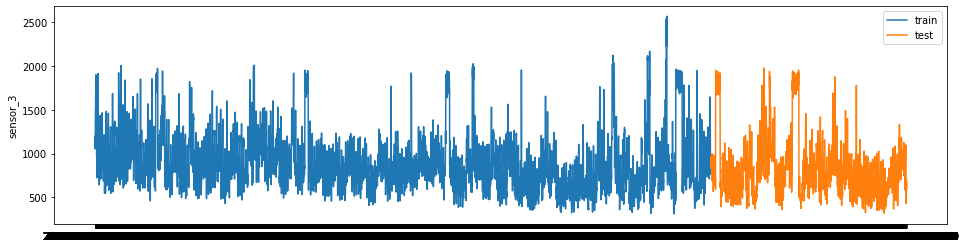

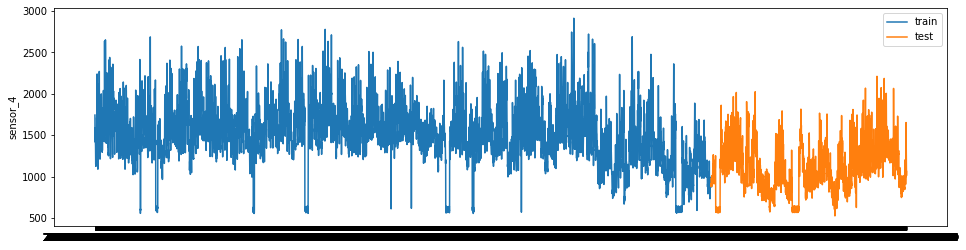

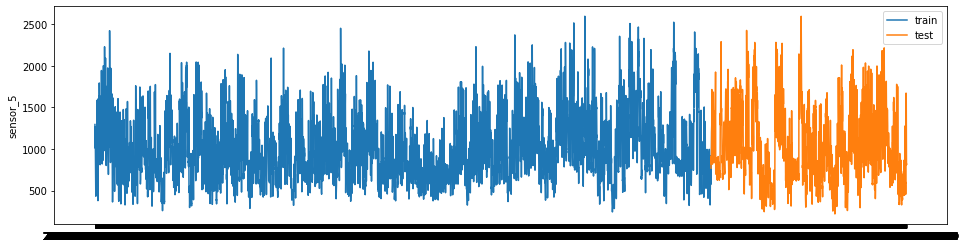

In [5]:
def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(df_train.index, df_train[name], label='train')
    plt.plot(df_test.index, df_test[name], label='test')
    plt.ylabel(name)
    plt.legend()
    plt.show()

for col in df_train[features].columns:
    plot_sensor(col)

In [51]:
def cycle_sin_cos_coder(data, cols):
    for col in cols:
        data[col + '_s'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_c'] = np.cos(2 * np.pi * data[col]/data[col].max())
    return data

In [52]:
df_all['month'] = df_all['date_time'].dt.month
df_all['day'] = df_all['date_time'].dt.day
df_all['hour'] = df_all['date_time'].dt.hour

df_all = cycle_sin_cos_coder(df_all, ['month','day','hour'])
df_all.drop(['month','day','hour'], axis=1, inplace=True)
df_all.set_index('date_time', inplace=True)

print(df_all.shape)

(9366, 14)


In [53]:
len(df_train)

7111

In [54]:
len(df_all)

9366

In [55]:
df_train = df_all[:len(df_train)]

df_train [targets] = targets_values
df_test = df_all[len(df_train):]

In [16]:
df_all.head()

deg_C  relative_humidity  absolute_humidity  sensor_1  \
date_time                                                                    
2010-03-10 18:00:00   13.1               46.0             0.7578    1387.2   
2010-03-10 19:00:00   13.2               45.3             0.7255    1279.1   
2010-03-10 20:00:00   12.6               56.2             0.7502    1331.9   
2010-03-10 21:00:00   11.0               62.4             0.7867    1321.0   
2010-03-10 22:00:00   11.9               59.0             0.7888    1272.0   

                     sensor_2  sensor_3  sensor_4  sensor_5  month_s  \
date_time                                                              
2010-03-10 18:00:00    1087.8    1056.0    1742.8    1293.4      1.0   
2010-03-10 19:00:00     888.2    1197.5    1449.9    1010.9      1.0   
2010-03-10 20:00:00     929.6    1060.2    1586.1    1117.0      1.0   
2010-03-10 21:00:00     929.0    1102.9    1536.5    1263.2      1.0   
2010-03-10 22:00:00     852.7    1180.9    1415.5    1132.2      1.0   

                          month_c     day_s     day_c    hour_s    hour_c  
date_time                                                                  
2010-03-10 18:00:00  6.123234e-17  0.897805 -0.440394 -0.979084  0.203456  
2010-03-10 19:00:00  6.123234e-17  0.897805 -0.440394 -0.887885  0.460065  
2010-03-10 20:00:00  6.123234e-17  0.897805 -0.440394 -0.730836  0.682553  
2010-03-10 21:00:00  6.123234e-17  0.897805 -0.440394 -0.519584  0.854419  
2010-03-10 22:00:00  6.123234e-17  0.897805 -0.440394 -0.269797  0.962917

In [11]:
df_test.head()

deg_C  relative_humidity  absolute_humidity  sensor_1  \
date_time                                                                    
2010-12-31 16:00:00   12.4               25.6             0.4185     926.2   
2010-12-31 17:00:00   12.1               29.3             0.4148    1000.5   
2010-12-31 18:00:00   10.2               32.0             0.4112     922.7   
2010-12-31 19:00:00    9.1               34.3             0.3958     957.9   
2010-12-31 20:00:00    9.2               32.0             0.3871    1000.5   

                     sensor_2  sensor_3  sensor_4  sensor_5       month_s  \
date_time                                                                   
2010-12-31 16:00:00     746.4     843.5     974.4     769.6 -2.449294e-16   
2010-12-31 17:00:00     883.0     834.4     926.3     913.9 -2.449294e-16   
2010-12-31 18:00:00     800.7     856.5     876.1     819.8 -2.449294e-16   
2010-12-31 19:00:00     741.9     970.3     915.1     866.0 -2.449294e-16   
2010-12-31 20:00:00     811.2     873.0     909.0     910.5 -2.449294e-16   

                     month_c         day_s  day_c    hour_s    hour_c  
date_time                                                              
2010-12-31 16:00:00      1.0 -2.449294e-16    1.0 -0.942261 -0.334880  
2010-12-31 17:00:00      1.0 -2.449294e-16    1.0 -0.997669 -0.068242  
2010-12-31 18:00:00      1.0 -2.449294e-16    1.0 -0.979084  0.203456  
2010-12-31 19:00:00      1.0 -2.449294e-16    1.0 -0.887885  0.460065  
2010-12-31 20:00:00      1.0 -2.449294e-16    1.0 -0.730836  0.682553

In [56]:
train, test = train_test_split(df_train, shuffle = False, train_size=0.8)

In [57]:
for i in train[features].columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    
    s_train = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_test = scaler.transform(test[i].values.reshape(-1,1))
    s_df_test = scaler.transform(df_test[i].values.reshape(-1,1))
    
    s_train = np.reshape(s_train,len(s_train))
    s_test = np.reshape(s_test,len(s_test))
    s_df_test = np.reshape(s_df_test,len(s_df_test))

    train[i] = s_train
    test[i] = s_test
    df_test[i] = s_df_test

In [58]:
len(train)

5688

In [59]:
len(test)

1423

In [60]:
n_steps

8

In [67]:
train.head(n_steps+4)


deg_C  relative_humidity  absolute_humidity  sensor_1  \
date_time                                                                       
2010-03-10 18:00:00 -0.633663          -0.069009          -0.460494  0.063670   
2010-03-10 19:00:00 -0.628713          -0.086575          -0.492515 -0.095652   
2010-03-10 20:00:00 -0.658416           0.186951          -0.468028 -0.017833   
2010-03-10 21:00:00 -0.737624           0.342535          -0.431843 -0.033898   
2010-03-10 22:00:00 -0.693069           0.257215          -0.429761 -0.106116   
2010-03-10 23:00:00 -0.727723           0.202008          -0.433727 -0.181430   
2010-03-11 00:00:00 -0.752475           0.174404          -0.458015 -0.147089   
2010-03-11 01:00:00 -0.772277           0.207026          -0.448201 -0.239646   
2010-03-11 02:00:00 -0.782178           0.350063          -0.453554 -0.271776   
2010-03-11 03:00:00 -0.762376           0.272271          -0.466541 -0.462491   
2010-03-11 04:00:00 -0.816832           0.279799          -0.471696 -0.565365   
2010-03-11 05:00:00 -0.717822           0.242158          -0.481511 -0.331172   

                     sensor_2  sensor_3  sensor_4  sensor_5  month_s  \
date_time                                                              
2010-03-10 18:00:00 -0.096887 -0.138979  0.008005 -0.113612      1.0   
2010-03-10 19:00:00 -0.345935  0.027326 -0.240120 -0.355385      1.0   
2010-03-10 20:00:00 -0.294279 -0.134042 -0.124741 -0.264581      1.0   
2010-03-10 21:00:00 -0.295028 -0.083857 -0.166758 -0.139458      1.0   
2010-03-10 22:00:00 -0.390230  0.007816 -0.269262 -0.251573      1.0   
2010-03-10 23:00:00 -0.583879  0.285538 -0.229362 -0.408362      1.0   
2010-03-11 00:00:00 -0.619065  0.372510 -0.271380 -0.561898      1.0   
2010-03-11 01:00:00 -0.665980  0.395898 -0.316532 -0.608284      1.0   
2010-03-11 02:00:00 -0.701915  0.512840 -0.441484 -0.658094      1.0   
2010-03-11 03:00:00 -0.803232  0.723923 -0.495362 -0.800334      1.0   
2010-03-11 04:00:00 -0.842660  0.713816 -0.413783 -0.851170      1.0   
2010-03-11 05:00:00 -0.802608  0.851560 -0.517133 -0.841328      1.0   

                          month_c     day_s     day_c        hour_s    hour_c  \
date_time                                                                       
2010-03-10 18:00:00  6.123234e-17  0.897805 -0.440394 -9.790841e-01  0.203456   
2010-03-10 19:00:00  6.123234e-17  0.897805 -0.440394 -8.878852e-01  0.460065   
2010-03-10 20:00:00  6.123234e-17  0.897805 -0.440394 -7.308360e-01  0.682553   
2010-03-10 21:00:00  6.123234e-17  0.897805 -0.440394 -5.195840e-01  0.854419   
2010-03-10 22:00:00  6.123234e-17  0.897805 -0.440394 -2.697968e-01  0.962917   
2010-03-10 23:00:00  6.123234e-17  0.897805 -0.440394 -2.449294e-16  1.000000   
2010-03-11 00:00:00  6.123234e-17  0.790776 -0.612106  0.000000e+00  1.000000   
2010-03-11 01:00:00  6.123234e-17  0.790776 -0.612106  2.697968e-01  0.962917   
2010-03-11 02:00:00  6.123234e-17  0.790776 -0.612106  5.195840e-01  0.854419   
2010-03-11 03:00:00  6.123234e-17  0.790776 -0.612106  7.308360e-01  0.682553   
2010-03-11 04:00:00  6.123234e-17  0.790776 -0.612106  8.878852e-01  0.460065   
2010-03-11 05:00:00  6.123234e-17  0.790776 -0.612106  9.790841e-01  0.203456   

                     target_carbon_monoxide  target_benzene  \
date_time                                                     
2010-03-10 18:00:00                1.252763        2.564949   
2010-03-10 19:00:00                1.131402        2.388763   
2010-03-10 20:00:00                1.163151        2.322388   
2010-03-10 21:00:00                1.163151        2.370244   
2010-03-10 22:00:00                0.916291        2.001480   
2010-03-10 23:00:00                0.788457        1.686399   
2010-03-11 00:00:00                0.788457        1.547563   
2010-03-11 01:00:00                0.693147        1.481605   
2010-03-11 02:00:00                0.641854        1.163151   
2010-03-11 03:00:00                0.470004        0

In [62]:
def split_sequences(Xsequences, ysequences, n_steps = 6, n_out = 1):
    X, y = list(), list()

    for i in range(len(Xsequences)):
        end_index = i + n_steps
        out_end_index = end_index + n_out
        
        if out_end_index > len(Xsequences):
            break
        
        seq_x = Xsequences.iloc[i : end_index, :] 
        if isinstance(ysequences, pd.core.series.Series):
            seq_y = ysequences.iloc[end_index : out_end_index]
            y.append(seq_y)

        X.append(seq_x)
        
    return array(X), array(y)

In [63]:
Xtrain_seq_tcm, ytrain_seq_tcm = split_sequences(train.drop(targets, axis = 1), train['target_carbon_monoxide'], n_steps, n_lookup)
Xtest_seq_tcm, ytest_seq_tcm = split_sequences(test.drop(targets, axis = 1), test['target_carbon_monoxide'], n_steps, n_lookup)



In [64]:
train.shape

(5688, 17)

In [65]:
Xtrain_seq_tcm.shape

(5677, 8, 14)

In [66]:
ytrain_seq_tcm[0]

array([0.64185389, 0.47000363, 0.53062825, 0.53062825])

In [68]:
Xtrain_seq_tb, ytrain_seq_tb = split_sequences(train.drop(targets, axis = 1), train['target_benzene'], n_steps, n_lookup)
Xtest_seq_tb, ytest_seq_tb = split_sequences(test.drop(targets, axis = 1), test['target_benzene'], n_steps, n_lookup)

Xtrain_seq_tno, ytrain_seq_tno = split_sequences(train.drop(targets, axis = 1), train['target_nitrogen_oxides'], n_steps, n_lookup)
Xtest_seq_tno, ytest_seq_tno = split_sequences(test.drop(targets, axis = 1), test['target_nitrogen_oxides'], n_steps, n_lookup)

n_features = Xtrain_seq_tcm.shape[2]

print(Xtrain_seq_tcm.shape, ytrain_seq_tcm.shape)
print(Xtest_seq_tcm.shape, ytest_seq_tcm.shape)

(5677, 8, 14) (5677, 4)
(1412, 8, 14) (1412, 4)


In [69]:
np.set_printoptions(suppress=True, linewidth=255)

Xtest_sub, _ = split_sequences(df_test, [], n_steps, n_lookup)
print(Xtest_sub[0])
print(Xtest_sub.shape)

[[-0.66831683 -0.58092848 -0.79686725 -0.61577008 -0.52286481 -0.38872892 -0.64293278 -0.56189824 -0.          1.         -0.          1.         -0.94226092 -0.33487961]
 [-0.68316832 -0.4880803  -0.80053534 -0.50626382 -0.35242373 -0.39942411 -0.68367995 -0.4384013  -0.          1.         -0.          1.         -0.99766877 -0.06824241]
 [-0.77722772 -0.42032622 -0.80410429 -0.62092852 -0.45511261 -0.37345008 -0.72620611 -0.51893534 -0.          1.         -0.          1.         -0.97908409  0.20345601]
 [-0.83168317 -0.36260979 -0.81937147 -0.56904937 -0.52847963 -0.23970147 -0.69316786 -0.47939578 -0.          1.         -0.          1.         -0.88788522  0.46006504]
 [-0.82673267 -0.42032622 -0.82799643 -0.50626382 -0.44201135 -0.35405771 -0.69833538 -0.44131114 -0.          1.         -0.          1.         -0.73083596  0.68255314]
 [-0.83168317 -0.3902133  -0.83840587 -0.47354458 -0.46846341 -0.2616795  -0.69503156 -0.44738756 -0.          1.         -0.          1.        

In [70]:
np.set_printoptions(suppress=True, linewidth=255)

num_seq_show = 3

for i in range(num_seq_show):
    print(f'X{i}\n {Xtrain_seq_tcm[i]}')
    print(f'y{i}\n {ytrain_seq_tcm[i]} \n\n')

X0
 [[-0.63366337 -0.06900878 -0.4604937   0.06366986 -0.09688689 -0.13897867  0.00800542 -0.11361205  1.          0.          0.89780454 -0.44039415 -0.97908409  0.20345601]
 [-0.62871287 -0.08657465 -0.49251512 -0.09565217 -0.34593549  0.02732562 -0.24012029 -0.35538534  1.          0.          0.89780454 -0.44039415 -0.88788522  0.46006504]
 [-0.65841584  0.18695107 -0.46802816 -0.01783346 -0.29427912 -0.13404243 -0.12474057 -0.26458128  1.          0.          0.89780454 -0.44039415 -0.73083596  0.68255314]
 [-0.73762376  0.3425345  -0.43184297 -0.03389831 -0.29502776 -0.08385732 -0.16675844 -0.13945826  1.          0.          0.89780454 -0.44039415 -0.51958395  0.8544194 ]
 [-0.69306931  0.25721455 -0.42976108 -0.10611643 -0.39023021  0.00781571 -0.26926172 -0.2515726   1.          0.          0.89780454 -0.44039415 -0.26979677  0.96291729]
 [-0.72772277  0.20200753 -0.43372658 -0.18142962 -0.58387922  0.28553799 -0.22936168 -0.4083615   1.          0.          0.89780454 -0.4403

In [71]:
def rmsle(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

In [85]:
model_tcm = Sequential()
model_tcm.add(LSTM(100, activation='tanh', input_shape=(n_steps, n_features)))
model_tcm.add(RepeatVector(n_lookup))
model_tcm.add(LSTM(100, activation='tanh', return_sequences=True))
model_tcm.add(TimeDistributed(Dense(1)))
model_tcm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)

model_tcm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               46000     
                                                                 
 repeat_vector (RepeatVector  (None, 4, 100)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4, 100)            80400     
                                                                 
 time_distributed (TimeDistr  (None, 4, 1)             101       
 ibuted)                                                         
                                                                 
Total params: 126,501
Trainable params: 126,501
Non-trainable params: 0
_________________________________________________________________


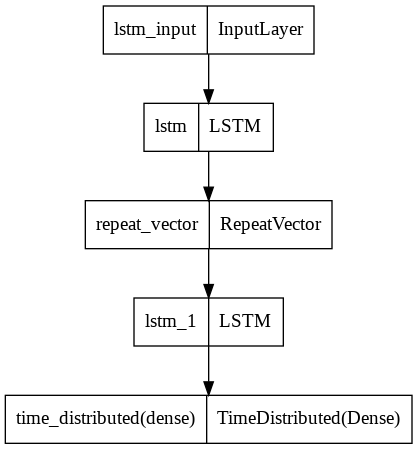

In [86]:
tf.keras.utils.plot_model(model_tcm)

In [87]:
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
red_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

def plot_model_learning(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [81]:
Xtrain_seq_tcm.shape

(5677, 8, 14)

In [82]:
ytrain_seq_tcm.shape

(5677, 4)

In [83]:
Xtest_seq_tcm.shape

(1412, 8, 14)

In [84]:
ytest_seq_tcm.shape

(1412, 4)

In [ ]:
N_SAMPLE = 20
yhat_tcm = np.zeros((Xtest_sub.shape[0],n_lookup))

for samples in tqdm(range(N_SAMPLE)):
    tf.keras.backend.clear_session()
    
    model_tcm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)
    history_tcm = model_tcm.fit(Xtrain_seq_tcm, ytrain_seq_tcm, 
                                validation_data = (Xtest_seq_tcm, ytest_seq_tcm), 
                                epochs=100, 
                                verbose = 0,
                                batch_size = 16, 
                                callbacks=[es, red_lr])
    
  
    yhat_tcm += np.expm1(model_tcm.predict(Xtest_sub)).reshape(-1,n_lookup)

yhat_tcm = yhat_tcm / N_SAMPLE

  0%|          | 0/20 [00:00<?, ?it/s]

71/71 [==============================] - 1s 5ms/step


In [39]:
yhat_tcm

array([[1.22496637],
       [1.30090477],
       [1.56459334],
       ...,
       [2.18142204],
       [2.1905639 ],
       [1.81554546]])

In [41]:
model_tno = Sequential()
model_tno.add(Conv1D(64, 3, activation='relu', input_shape=(n_steps, n_features)))
model_tno.add(Conv1D(64, 3, activation='relu'))
model_tno.add(MaxPooling1D())
model_tno.add(Flatten())
model_tno.add(RepeatVector(n_lookup))
model_tno.add(LSTM(100, activation='relu', return_sequences=True))
model_tno.add(TimeDistributed(Dense(64, activation='relu')))
model_tno.add(TimeDistributed(Dense(1)))

model_tno.compile(loss='mse', optimizer='adam')

model_tno.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             2752      
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 64)             12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 128)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 100)            9

In [42]:
N_SAMPLE = 20
yhat_tno = np.zeros((Xtest_sub.shape[0],1))

for samples in tqdm(range(N_SAMPLE)):
    tf.keras.backend.clear_session()
    
    model_tno.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= rmsle)
    history_tno = model_tno.fit(Xtrain_seq_tno, ytrain_seq_tno, 
                            validation_data = (Xtest_seq_tno, ytest_seq_tno), 
                            epochs=100, 
                            verbose = 0, 
                            batch_size = 16, 
                            callbacks=[es, red_lr])
    
  
    yhat_tno += np.expm1(model_tno.predict(Xtest_sub)).reshape(-1,1)

yhat_tno = yhat_tno / N_SAMPLE

  0%|          | 0/20 [00:00<?, ?it/s]

71/71 [==============================] - 0s 3ms/step


In [43]:
yhat_tno

array([[220.29333725],
       [184.0202507 ],
       [209.80699997],
       ...,
       [162.04690475],
       [136.77759323],
       [113.26693878]])

In [48]:
df_sub.head()

date_time  target_carbon_monoxide  target_benzene  \
0  2011-01-01 00:00:00                     2.0            10.0   
1  2011-01-01 01:00:00                     2.0            10.0   
2  2011-01-01 02:00:00                     2.0            10.0   
3  2011-01-01 03:00:00                     2.0            10.0   
4  2011-01-01 04:00:00                     2.0            10.0   

   target_nitrogen_oxides  
0                   300.0  
1                   300.0  
2                   300.0  
3                   300.0  
4                   300.0

In [47]:
yhat_tno.shape

(2247, 1)

# Lending Club Group Case Study

<a id='prob_stmt'/>

# <u>1. Problem statement:</u>
 
The XYZ consumer finance company is a front-runner in lending different kinds of loans of whose the customers recurrently being from the urban places of the country. The company abides by the policies and puts every loan application, it receives, against a screening process keeping the applicant's profile and their financial grounds in mind. 

The bank needs to take necessary steps to improve its business acumen by admitting new customers, however, at the same time it needs to cater the risk of loss, if any, due to the customer's profile of credit standpoint. -
1. Losing a valued customer would mean loss of business and
2. Lending loan to a customer with bad credit profile would expose it to the ramification of recoveries and losing reputation, world over. <BR><BR>

**<u>Objectives:</u>**
The bank has decided to work with us in identifying the top parameters (Influencers) that could make the process of lending the loans to a new customer , a risk-free approach. The prime objective of this exercise is to use our EDA analysis over the  bank's historical loan dataset of its customers who have been issued with various kinds of loans from the year 2007 through 2011 and help the bank to -
1. Identify the top driving/influencing factors that could lead a customer being defaulted.
2. Analyze the application in a way it would be easy to forsee whether bank should lend the loan or not.


***

<a id='top' />

# Code Flow:

1. [**Problem Statement**](#prob_stmt)
2. [**Data Cleaning**](#data_cleaning)<BR>
     2.a [Fixing Rows & Columns](#data_cleaning)<BR>
     2.b [Drop null columns and columns with unique values](#drop_null_cols)<BR>
     2.c [Handle Missing Values](#handle_missing_values)<BR>
     2.d [Standardize values](#stand_stmt)<BR>
3. [**Univariate analysis**](#univariate) <BR>
     3.a [Univariate analysis of driving factors](#univariate_influencers) <BR>
     3.b [Univariate analysis of Non-influencers](#univariate_non_influencers) <BR>
     3.c [Segmented Univariate Analysis](#segmented_univariate_analysis) <BR>
     3.d [Summary of Univariate Analysis](#summary_univariate_analysis) <BR>
4. [**Bivariate Analysis**](#bivariate_analysis) <BR>
     4.a [Correlation matrix](#corr_matrix) <BR>
     4.b [Bivariate analysis of Numerical Analysis](#bivariate_numerical) <BR>
     4.c [Bivariate analysis of Categorical Analysis](#bivariate_categorical) <BR>
5. [**Final Conclusions**](#final_conclusion)
    
<font color=blue, size=2> <B><u>Note:</u></B> Please use the aforementioned links to navigate through sections. Also, there are links provided at each sections, within the code, to navigate to/fro sections
     

***

### Import all necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytz
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#loan = pd.read_csv("/Users/ram/Downloads/loan.csv", encoding = "UTF-8")
loan = pd.read_csv('https://cdn.upgrad.com/UpGrad/temp/3ba74fb7-bd88-4854-8597-1c225a5aed99/loan.zip', encoding="ISO-8859-1")
#loan = pd.read_csv("loan.csv", encoding = "ISO-8859-1")

Go to: [Top](#top) <BR>
Go to: [Univariate Analysis](#univariate)
<a id='data_cleaning'/>

***

# 2. Data Cleaning

## 2.a Fixing rows and columns
### Verify the percentage of null values in each column

In [ ]:
(loan.isnull().sum()/len(loan))*100

id                                  0.000000
member_id                           0.000000
loan_amnt                           0.000000
funded_amnt                         0.000000
funded_amnt_inv                     0.000000
term                                0.000000
int_rate                            0.000000
installment                         0.000000
grade                               0.000000
sub_grade                           0.000000
emp_title                           6.188786
emp_length                          0.000000
home_ownership                      0.000000
annual_inc                          0.000000
verification_status                 0.000000
issue_d                             0.000000
loan_status                         0.000000
pymnt_plan                          0.000000
url                                 0.000000
desc                               32.577989
purpose                             0.000000
title                               0.025178
zip_code  

### Drop all columns which have null values on all rows

In [ ]:
loan.dropna(axis = 1, how = 'all', inplace = True)

In [ ]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
id                            39717 non-null int64
member_id                     39717 non-null int64
loan_amnt                     39717 non-null int64
funded_amnt                   39717 non-null int64
funded_amnt_inv               39717 non-null float64
term                          39717 non-null object
int_rate                      39717 non-null object
installment                   39717 non-null float64
grade                         39717 non-null object
sub_grade                     39717 non-null object
emp_title                     37259 non-null object
emp_length                    39717 non-null object
home_ownership                39717 non-null object
annual_inc                    39717 non-null float64
verification_status           39717 non-null object
issue_d                       39717 non-null object
loan_status                   39717 non-null object
pymnt_pl

### Verify the percentage of null values in the remaining columns to remove the ones which predominantly have null

In [ ]:
(loan.isnull().sum()/len(loan))*100

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      6.188786
emp_length                     0.000000
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.577989
purpose                        0.000000
title                          0.025178
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


### Drop the columns 'next_pymnt_d' and 'mths_since_last_record' since they have over 90% null values

In [ ]:
loan.drop(['next_pymnt_d', 'mths_since_last_record'], 1, inplace = True)

In [ ]:
(loan.isnull().sum()/len(loan))*100

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      6.188786
emp_length                     0.000000
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.577989
purpose                        0.000000
title                          0.025178
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


### Remove all rows which have loan status as "Current" as these rows give no insights about lender behavior

In [ ]:
loan = loan[loan.loan_status != "Current"]

### Remove any column which has over 60% of rows as null and 'desc' column

In [ ]:
loan.drop('mths_since_last_delinq', 1, inplace = True)
loan.drop('desc', 1, inplace = True)

In [ ]:
loan[['purpose', 'title']].head(20)

purpose                                  title
0          credit_card                               Computer
1                  car                                   bike
2       small_business                   real estate business
3                other                               personel
5              wedding  My wedding loan I promise to pay back
6   debt_consolidation                                   Loan
7                  car                        Car Downpayment
8       small_business   Expand Business & Buy Debt Portfolio
9                other            Building my credit history.
10  debt_consolidation             High intrest Consolidation
11  debt_consolidation                          Consolidation
12  debt_consolidation                                freedom
13         credit_card                          citicard fund
14               other                             Other Loan
15  debt_consolidation                Debt Consolidation Loan
16    home_improvement                                   Home
17      major_purchase                                Holiday
18             medical                                Medical
19  debt_consolidation    lowerratemeanseasiertogetoutofdebt!
20  debt_consolidation              Freedom From Credit Cards

In [ ]:
loan.purpose.unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [ ]:
loan.title.unique()

array(['Computer', 'bike', 'real estate business', ...,
       'Retiring credit card debt', 'MBA Loan Consolidation', 'JAL Loan'], dtype=object)

### Remove 'title' column as it is redundant. The 'purpose' column provides enough info regarding loan purpose.

In [ ]:

loan.drop('title', 1, inplace = True)

In [ ]:
(loan.isnull().sum()/len(loan))*100

id                            0.000000
member_id                     0.000000
loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
grade                         0.000000
sub_grade                     0.000000
emp_title                     6.182440
emp_length                    0.000000
home_ownership                0.000000
annual_inc                    0.000000
verification_status           0.000000
issue_d                       0.000000
loan_status                   0.000000
pymnt_plan                    0.000000
url                           0.000000
purpose                       0.000000
zip_code                      0.000000
addr_state                    0.000000
dti                           0.000000
delinq_2yrs                   0.000000
earliest_cr_line              0.000000
inq_last_6mths           

In [ ]:
loan.url.unique()

array(['https://lendingclub.com/browse/loanDetail.action?loan_id=1077501',
       'https://lendingclub.com/browse/loanDetail.action?loan_id=1077430',
       'https://lendingclub.com/browse/loanDetail.action?loan_id=1077175',
       ...,
       'https://lendingclub.com/browse/loanDetail.action?loan_id=90395',
       'https://lendingclub.com/browse/loanDetail.action?loan_id=90376',
       'https://lendingclub.com/browse/loanDetail.action?loan_id=87023'], dtype=object)

### Remove URL column as it does not help with the analysis. Loan ID is available as a separate column.

In [ ]:
loan.drop('url', 1, inplace = True)

In [ ]:
loan.emp_title.nunique()/loan.emp_title.count()

0.77442528735632188

### Attempt to clean up emp_title column

In [ ]:
import re

loan_data_string_columns = loan.select_dtypes(['object'])
loan[loan_data_string_columns.columns] = loan_data_string_columns.apply(lambda x: x.str.strip())

loan['emp_title'].fillna('Unknown', inplace=True)

#Start cleaning of the emp_title column
print("Number of unique entries in emp_title before cleanup: {0}".format(len(loan['emp_title'].unique())))
loan['emp_title'] = loan['emp_title'].astype(str).str.lower()
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(".", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(",", " "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(";", " "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(":", " "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("-", " "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("/", " "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("'", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("(", " "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(")", " "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: re.sub('\s+', ' ', x))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" inc ", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" incorporated ", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" corp ", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" corporation ", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" ltd ", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" limited ", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" llc ", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" pa ", ""))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" co ", " company "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" + ", " and "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" & ", " and "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace(" hr ", " hour "))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("united sates", "united states"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("united staes", "united states"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("united state", "united states"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("united states ostal service", "united states postal service"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("univ ", "university"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("veteran adm", "veterans administration"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("veterans admin", "veterans administration"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("veterans affairs", "veterans affairs department (VA)"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("walgreen", "walgreens"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("walgreens co", "walgreens"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("walgreen company", "walgreens"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("wal-mart", "walmart"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("walt disney co", "walt disney"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("walt disney company", "walt disney"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("walt disney world co", "walt disney world"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("walt disney world resorts", "walt disney world"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("walt disney world resort", "walt disney world"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("wipro limited", "wipro"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("wellsfargo", "wells fargo"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("24hour", "24 hour"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: x.replace("united states", "us"))
loan['emp_title'] = loan['emp_title'].apply(lambda x: re.sub('\s+', ' ', x))

print("Number of unique entries in emp_title after cleanup: {0}".format(len(loan['emp_title'].unique())))
loan_data = loan[~(loan['emp_title'].astype(str).str.isdigit())]


Number of unique entries in emp_title before cleanup: 27831
Number of unique entries in emp_title after cleanup: 25855


In [ ]:
loan.emp_title.nunique()/loan.emp_title.count()

0.6702180055473469

In [ ]:
loan.emp_title.unique()

array(['unknown', 'ryder', 'air resources board', ..., 'fisite research',
       'squarewave solutions ltd', 'evergreen center'], dtype=object)

### "emp_title" column has over 67% unique values and may not aid towards the analysis

Go to: [Top](#top)<BR>
Go to: [Data Cleaning](#data_cleaning)<BR>
Go to: [Fixing Rows & Columns](#data_cleaning)<BR>
<a id='drop_null_cols' />

## 2.b Dropping null columns and columns that have unique values

### Below columns have only one unique value and can be dropped

In [ ]:
loan.pymnt_plan.unique()

array(['n'], dtype=object)

In [ ]:
loan.initial_list_status.unique()

array(['f'], dtype=object)

In [ ]:
loan.collections_12_mths_ex_med.unique()

array([  0.,  nan])

In [ ]:
loan.policy_code.unique()

array([1], dtype=int64)

In [ ]:
loan.application_type.unique()

array(['INDIVIDUAL'], dtype=object)

In [ ]:
loan.acc_now_delinq.unique()

array([0], dtype=int64)

In [ ]:
loan.chargeoff_within_12_mths.unique()

array([  0.,  nan])

In [ ]:
loan.delinq_amnt.unique()

array([0], dtype=int64)

In [ ]:
loan.tax_liens.unique()

array([  0.,  nan])

In [ ]:
loan.out_prncp.unique()

array([ 0.])

In [ ]:
loan.out_prncp_inv.unique()

array([ 0.])

### Dropping all columns with only one unique value

In [ ]:
loan.drop(['pymnt_plan',
           'initial_list_status',
           'policy_code',
           'application_type',
           'tax_liens',
           'acc_now_delinq',
           'chargeoff_within_12_mths',
           'delinq_amnt',
           'collections_12_mths_ex_med',
           'out_prncp',
           'out_prncp_inv',
           'member_id'],axis=1,inplace=True)

In [ ]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 39 columns):
id                         38577 non-null int64
loan_amnt                  38577 non-null int64
funded_amnt                38577 non-null int64
funded_amnt_inv            38577 non-null float64
term                       38577 non-null object
int_rate                   38577 non-null object
installment                38577 non-null float64
grade                      38577 non-null object
sub_grade                  38577 non-null object
emp_title                  38577 non-null object
emp_length                 38577 non-null object
home_ownership             38577 non-null object
annual_inc                 38577 non-null float64
verification_status        38577 non-null object
issue_d                    38577 non-null object
loan_status                38577 non-null object
purpose                    38577 non-null object
zip_code                   38577 non-null object
addr_stat

In [ ]:
(loan.isnull().sum()/len(loan))*100

id                         0.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
term                       0.000000
int_rate                   0.000000
installment                0.000000
grade                      0.000000
sub_grade                  0.000000
emp_title                  0.000000
emp_length                 0.000000
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
issue_d                    0.000000
loan_status                0.000000
purpose                    0.000000
zip_code                   0.000000
addr_state                 0.000000
dti                        0.000000
delinq_2yrs                0.000000
earliest_cr_line           0.000000
inq_last_6mths             0.000000
open_acc                   0.000000
pub_rec                    0.000000
revol_bal                  0.000000
revol_util                 0.129611
total_acc                  0

### Find out the rows which have over 10% of the columns as null.

In [ ]:
len(loan[loan.isnull().sum(axis=1)/len(loan.columns)>0.1])

0

#### There are no rows which have more than 10% of their columns null hence, this concludes row cleanup

Go to: [Top](#top)<BR>
Go to: [2.a Fixing Rows & Columns](#data_cleaning)<BR>
Go to: [2.b Drop null columns & columns with unique value](#drop_null_cols)<BR>
Go to: [3 Univariate Analysis](#univariate)<BR>
<a id='handle_missing_values' />

## 2.c Handling missing values

In [ ]:
loan.pub_rec_bankruptcies.describe()

count    37880.000000
mean         0.043479
std          0.204583
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64

### Column "pub_rec_bankruptcies" has discrete values 0, 1, 2.
### It's median is the most representative value since till 75% the value is 0. Reported bankruptcies appear to be outliers.
### Hence, replacing all nulls with 0.

In [ ]:
loan.pub_rec_bankruptcies.fillna(0.0, inplace=True)

In [ ]:
(loan.isnull().sum()/len(loan))*100

id                         0.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
term                       0.000000
int_rate                   0.000000
installment                0.000000
grade                      0.000000
sub_grade                  0.000000
emp_title                  0.000000
emp_length                 0.000000
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
issue_d                    0.000000
loan_status                0.000000
purpose                    0.000000
zip_code                   0.000000
addr_state                 0.000000
dti                        0.000000
delinq_2yrs                0.000000
earliest_cr_line           0.000000
inq_last_6mths             0.000000
open_acc                   0.000000
pub_rec                    0.000000
revol_bal                  0.000000
revol_util                 0.129611
total_acc                  0

### Describing the below columns to understand the scope to replace the null values

In [ ]:
loan.last_credit_pull_d.describe()

count      38575
unique       106
top       May-16
freq        9333
Name: last_credit_pull_d, dtype: object

In [ ]:
loan.last_pymnt_d.describe()

count      38506
unique       101
top       Mar-13
freq        1026
Name: last_pymnt_d, dtype: object

In [ ]:
loan.revol_util.describe()

count     38527
unique     1088
top          0%
freq        954
Name: revol_util, dtype: object

In [ ]:
loan.revol_util.unique()

array(['83.70%', '9.40%', '98.50%', ..., '49.63%', '0.04%', '7.28%'], dtype=object)

#### Standardize "revol_util" column to understand the scope to replace null values

In [ ]:
loan.revol_util = loan.revol_util.apply(lambda x : float(str(x).rstrip('%')))

In [ ]:
loan.revol_util = loan.revol_util.apply(lambda x : round(x,1))

In [ ]:
loan.revol_util = loan.revol_util.apply(lambda x : round((x/100),2))

In [ ]:
loan.revol_util.unique()

array([ 0.84,  0.09,  0.98,  0.21,  0.28,  0.86,  0.88,  0.33,  0.36,
        0.67,  0.92,  0.43,  0.56,  0.81,  0.7 ,  0.16,  0.38,  0.23,
        0.9 ,  0.82,  0.3 ,  0.94,  0.58,  0.59,  0.87,  0.27,  0.29,
        0.6 ,  0.57,  0.13,  0.5 ,  0.18,  0.99,  0.62,  0.52,  0.2 ,
        0.64,  0.93,  0.91,  0.75,  0.73,  0.46,  0.71,  0.83,  0.74,
        0.8 ,  0.79,  0.68,  0.97,  0.55,  0.65,  0.07,  0.78,  0.53,
        0.14,  0.96,  0.51,  0.48,  0.37,  0.22,  0.47,  0.49,  0.54,
        0.77,  0.35,  0.01,  0.31,  0.72,  0.41,  0.61,  0.66,  0.69,
        0.42,  0.95,  0.76,  0.89,  0.85,  0.26,  0.39,  0.19,  0.34,
        0.24,  0.1 ,  0.04,  0.4 ,  0.45,  0.03,  0.44,  0.08,  0.06,
        0.12,  0.25,  0.63,  1.  ,  0.17,  0.  ,  0.15,  0.05,  0.32,
        0.11,  0.02,   nan])

In [ ]:
loan.revol_util.describe()

count    38527.000000
mean         0.487034
std          0.283666
min          0.000000
25%          0.250000
50%          0.490000
75%          0.720000
max          1.000000
Name: revol_util, dtype: float64

#### revol_util appears to be a normally distributed column since mean and median are approximately equal.
#### Replacing the null values with median i.e., 0.49

In [ ]:
loan.revol_util.fillna(round(float(0.49),2), inplace=True)

In [ ]:
loan.revol_util.describe()

count    38577.000000
mean         0.487038
std          0.283482
min          0.000000
25%          0.250000
50%          0.490000
75%          0.720000
max          1.000000
Name: revol_util, dtype: float64

#### Mean, median and other statistical parameters remain unaffected after the replacement of null values

In [ ]:
(loan.isnull().sum()/len(loan))*100

id                         0.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
term                       0.000000
int_rate                   0.000000
installment                0.000000
grade                      0.000000
sub_grade                  0.000000
emp_title                  0.000000
emp_length                 0.000000
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
issue_d                    0.000000
loan_status                0.000000
purpose                    0.000000
zip_code                   0.000000
addr_state                 0.000000
dti                        0.000000
delinq_2yrs                0.000000
earliest_cr_line           0.000000
inq_last_6mths             0.000000
open_acc                   0.000000
pub_rec                    0.000000
revol_bal                  0.000000
revol_util                 0.000000
total_acc                  0

In [ ]:
loan.emp_length.unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', 'n/a'], dtype=object)

In [ ]:
loan.emp_length.isnull().sum()

0

In [ ]:
loan.last_pymnt_d.isnull().sum()

71

In [ ]:
loan.revol_util.isnull().sum()

0

In [ ]:
loan.last_credit_pull_d.isnull().sum()

2

#### Remove all rows with null value in last_pymnt_d, last_credit_pull_d & last_pymnt_d as the count is insignificant

In [ ]:
loan.dropna(subset=['last_credit_pull_d','last_pymnt_d','revol_util','emp_length'],inplace=True)

### Final column list after fixing invalid values

In [ ]:
(loan.isnull().sum()/len(loan))*100

id                         0.0
loan_amnt                  0.0
funded_amnt                0.0
funded_amnt_inv            0.0
term                       0.0
int_rate                   0.0
installment                0.0
grade                      0.0
sub_grade                  0.0
emp_title                  0.0
emp_length                 0.0
home_ownership             0.0
annual_inc                 0.0
verification_status        0.0
issue_d                    0.0
loan_status                0.0
purpose                    0.0
zip_code                   0.0
addr_state                 0.0
dti                        0.0
delinq_2yrs                0.0
earliest_cr_line           0.0
inq_last_6mths             0.0
open_acc                   0.0
pub_rec                    0.0
revol_bal                  0.0
revol_util                 0.0
total_acc                  0.0
total_pymnt                0.0
total_pymnt_inv            0.0
total_rec_prncp            0.0
total_rec_int              0.0
total_re

<a id='stand_stmt'/>

## 2.d Standardize values

In [ ]:
loan.int_rate = loan.int_rate.apply(lambda x : round((float(str(x).rstrip('%'))/100),2))

In [ ]:
loan.int_rate.unique()

array([ 0.11,  0.15,  0.16,  0.13,  0.08,  0.19,  0.21,  0.1 ,  0.06,
        0.12,  0.17,  0.09,  0.18,  0.07,  0.2 ,  0.14,  0.22,  0.24,
        0.23,  0.05])

#### Interest rate converted from percentage to fraction

In [ ]:
loan.emp_length.unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', 'n/a'], dtype=object)

#### Standardize emp_length - Replace '10+' with 10, '<1' as 0, remove nulls and convert values to int

In [ ]:
loan.emp_length = loan.emp_length.apply(lambda x:x.rstrip(' years'))

In [ ]:
loan.emp_length[loan.emp_length == '10+'] = "10"

In [ ]:
loan.emp_length[loan.emp_length == '< 1'] = "0"
loan.shape

(38504, 39)

In [ ]:
loan = loan[loan['emp_length'].str.isdigit() == True]
loan.shape

(37476, 39)

In [ ]:
loan['emp_length']=loan['emp_length'].astype(int)

In [ ]:
loan['last_pymnt_d']=pd.to_datetime(loan['last_pymnt_d'],format='%b-%y')
loan['last_credit_pull_d']=pd.to_datetime(loan['last_credit_pull_d'],format='%b-%y')
loan['issue_d']=pd.to_datetime(loan['issue_d'],format='%b-%y')
loan['last_pymnt_year'] = pd.DatetimeIndex(loan['last_pymnt_d']).year
loan['last_pymnt_months'] = (loan['last_pymnt_d'] - loan['issue_d'])/np.timedelta64(1, 'M')

In [ ]:
loan['earliest_cr_line']=pd.to_datetime(loan['earliest_cr_line'],format='%b-%y')
loan['earliest_cr_line'] = pd.DatetimeIndex(loan['earliest_cr_line'])
loan['earliest_cr_line_year'] = loan['earliest_cr_line'].apply(lambda x: x.year if (x.year <= 2008) else (x.year - 100))
loan['earliest_cr_line_year'] = loan['earliest_cr_line_year'].astype('category')

#### Creating bin columns for comparison for the relevant quantitative variables

In [ ]:
loan_data_string_columns = list(['loan_amnt','int_rate', 'installment', 'annual_inc', 'dti','open_acc','revol_util'])
for column in loan_data_string_columns:
    range_column = '{0}_ranges'.format(column)
    loan[range_column] = pd.qcut(loan[column], [0, .2, .4, .5, .6, .8, 1]) 

#### Creating function to return percentage of each category of a column

In [ ]:
def getPercData(columnName, ldf):
    loan_df_term_perc = ldf.groupby(by=[columnName,'loan_status']).count().groupby(level=[0]).apply(lambda x: x / x.sum())
    loan_df_term_perc = loan_df_term_perc.reset_index()
    loan_df_term_perc = loan_df_term_perc[[columnName,'loan_status','id']]
    return loan_df_term_perc

In [ ]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def get_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

loan['region'] = loan['addr_state'].apply(get_regions)

In [ ]:
loan['annual_inc'].describe(percentiles=[.33,.66])

count    3.747600e+04
mean     6.944199e+04
std      6.472029e+04
min      4.000000e+03
33%      4.700000e+04
50%      6.000000e+04
66%      7.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [ ]:
loan.loc[loan['annual_inc'] <= 47000, 'income_category'] = 'Low'
loan.loc[(loan['annual_inc'] > 47000) & (loan['annual_inc'] < 72000) , 'income_category'] = 'Medium'
loan.loc[loan['annual_inc'] >=72000 , 'income_category'] = 'High'

### 2.d: <u>Summary of Standardization:</u><BR><BR> As a result of Standardization, following columns have been identified and Standardize accordingly.

#### 1. int_rate
       * Removed % and converted into float
#### 2. emp_length
        * Converted 10+ as 10 and <1 as 0
#### 3. last_pymnt_d, last_credit_pull_d, issue_d, earliest_cr_line
        * Converted to DateTime datatype
### <u>Derived Colums</u>
#### 1. Column Range for quantitative variables
#### 2. last_pymnt_year
#### 3. last_pymnt_months
#### 4. earliest_cr_line_year
#### 5. region
#### 6. income_category <BR><BR>

Go to: [Top](#top) <BR>
Go to: [Data Cleaning](#data_cleaning)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis) 
<a id='univariate' />

***

# 3. Univariate Plots & analysis <a id= 'univariate_influencers' />

## 3.a Univariate Analysis of driving factors/ influencers

### Visualize the count of "Fully Paid" loans against "Charged Off"

In [ ]:
sns.set_style("darkgrid")

In [ ]:
perc_charged_off_in_data = len(loan[loan['loan_status'] == 'Charged Off'])/len(loan)
print("Percentage of Charged Off loans in dataset : {0}".format(round(perc_charged_off_in_data, 3)))

Percentage of Charged Off loans in dataset : 0.142


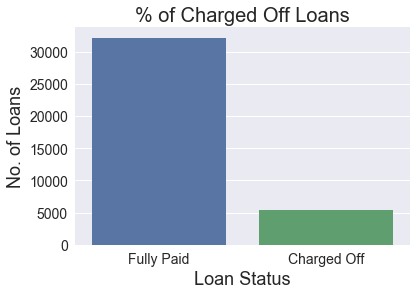

In [ ]:
total_charged_off_perc = sns.countplot('loan_status',data=loan)
plt.xlabel('Loan Status', fontsize=18)
plt.ylabel('No. of Loans', fontsize=18)
plt.setp(total_charged_off_perc.get_xticklabels(), fontsize=14)
plt.setp(total_charged_off_perc.get_yticklabels(), fontsize=14)
total_charged_off_perc.set_title('% of Charged Off Loans', fontsize=20)

### Univariate analysis for col: verification_status analysis

In [ ]:
loan.verification_status.describe()

count            37476
unique               3
top       Not Verified
freq             16242
Name: verification_status, dtype: object

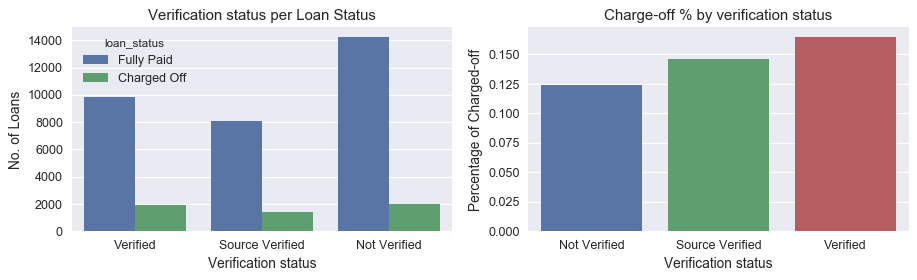

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.countplot('verification_status',hue='loan_status',data=loan,ax=ax1)
ax1.set_xlabel('Verification status')
ax1.set_ylabel('No. of Loans')
ax1.set_title('Verification status per Loan Status')
charge_off_rates = loan.groupby('verification_status')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, ax=ax2)
ax2.set_xlabel('Verification status')
ax2.set_ylabel('Percentage of Charged-off')
ax2.set_title('Charge-off % by verification status')

### Conclusion: Ratio of charged off vs full paid doesn't vary considerably across different verification_status so this field is not an influencer

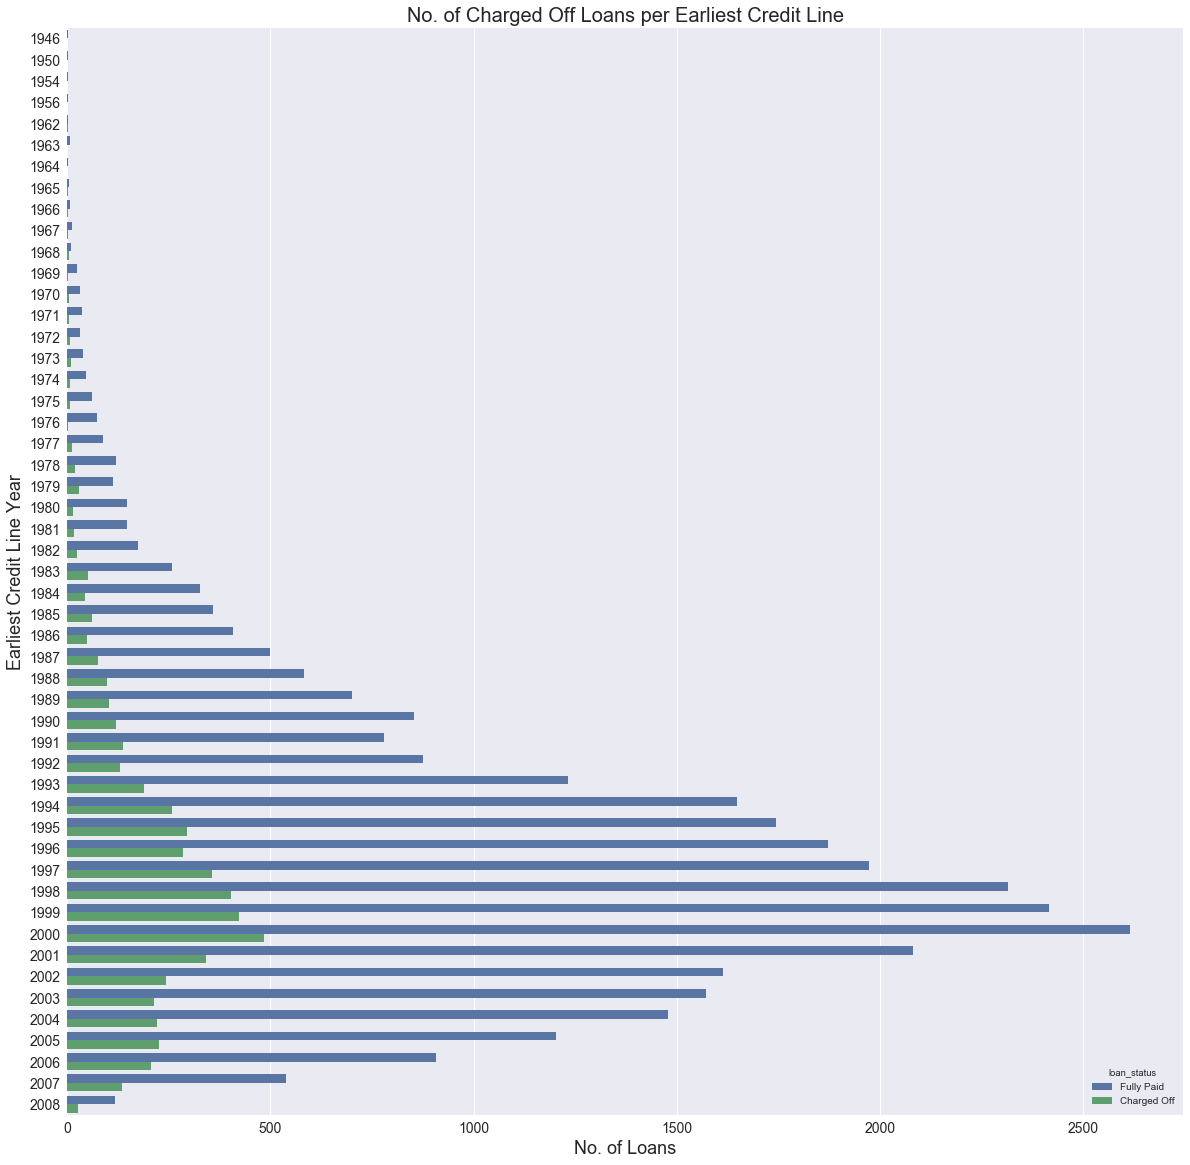

In [ ]:
plt.figure(figsize=[20,20])
cr_plot = sns.countplot(y='earliest_cr_line_year', hue='loan_status',data=loan)
plt.ylabel('Earliest Credit Line Year', fontsize=18)
plt.xlabel('No. of Loans', fontsize=18)
plt.setp(cr_plot.get_xticklabels(), fontsize=14)
plt.setp(cr_plot.get_yticklabels(), fontsize=14)
cr_plot.set_title('No. of Charged Off Loans per Earliest Credit Line', fontsize=20)
plt.show()

### Conclusion: Ratio of charged off vs full paid doesn't vary considerably across different Credit line years, so this field is not an influencer

In [ ]:
def setLabels(plot, xLabel, yLabel, title):
    plt.ylabel(yLabel, fontsize=18)
    plt.xlabel(xLabel, fontsize=18)
    plt.setp(plot.get_xticklabels(), fontsize=14)
    plt.setp(plot.get_yticklabels(), fontsize=14)
    plot.set_title(title, fontsize=20)

In [ ]:
def createCountPlot(varName, xLabel, yLabel, title):
    count_plot = sns.countplot(varName, hue='loan_status',data=loan)
    setLabels(count_plot, xLabel, yLabel, title)

In [ ]:
def createPercPlot(varName, xLabel, yLabel, title):
    charge_off_rates = loan.groupby(varName)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
    perc_plot = sns.barplot(x=charge_off_rates.reset_index()[varName], y=charge_off_rates.values)
    setLabels(perc_plot, xLabel, yLabel, title)

In [ ]:
def createBarPlot(varName, xLabel, yLabel, title):
    bar_plot = sns.barplot(y=varName, x='loan_status',data=loan)
    setLabels(bar_plot, xLabel, yLabel, title)

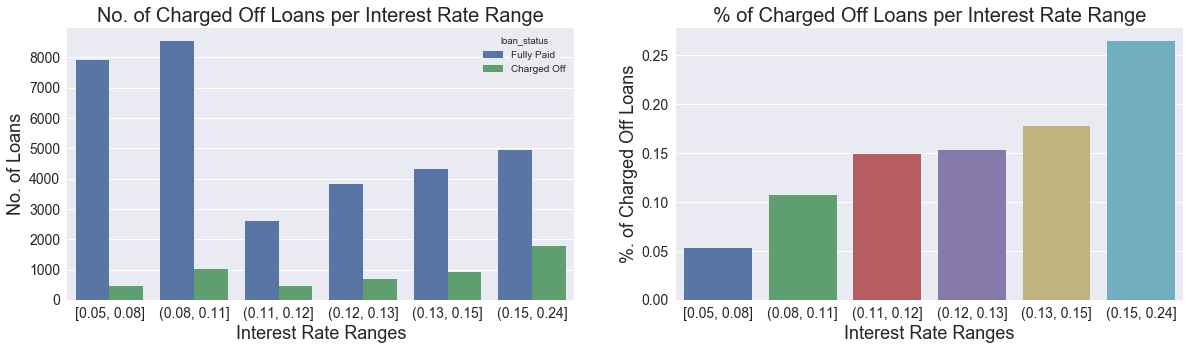

In [ ]:
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
createCountPlot('int_rate_ranges', 'Interest Rate Ranges', 'No. of Loans', 'No. of Charged Off Loans per Interest Rate Range')

plt.subplot(1,2,2)
createPercPlot('int_rate_ranges', 'Interest Rate Ranges', '%. of Charged Off Loans', '% of Charged Off Loans per Interest Rate Range')

### Conclusion: Ratio of charged off vs full paid varies lesser across different interest ranges, so this field is a mild influencer

### Univariate analysis for col: DTI (Debt to Income ratio)

In [ ]:
loan.dti.unique()

array([ 27.65,   1.  ,   8.72, ...,   0.05,   0.12,  25.43])

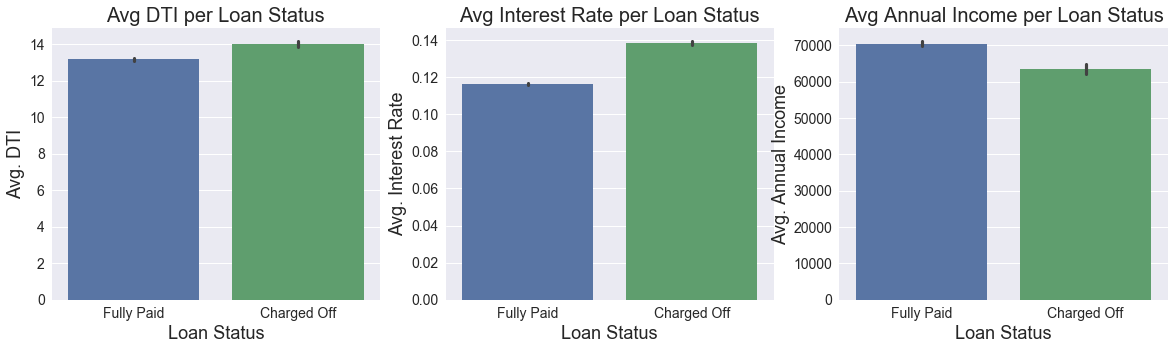

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
createBarPlot('dti', 'Loan Status', 'Avg. DTI', 'Avg DTI per Loan Status')
plt.subplot(1,3,2)
createBarPlot('int_rate', 'Loan Status', 'Avg. Interest Rate', 'Avg Interest Rate per Loan Status')
plt.subplot(1,3,3)
createBarPlot('annual_inc', 'Loan Status', 'Avg. Annual Income', 'Avg Annual Income per Loan Status')
plt.show()

### Conclusion: Customers who have charged off have more int_rate and dti than the fully paid ones on an average hence these are influencers. Income is one of the components used to calculate dti so annual_inc will be dropped for further analysis

### delinq_2yrs (Number of delinquency in the last 2 years) analysis

In [ ]:
loan.delinq_2yrs.unique()

array([ 0,  2,  3,  1,  4,  6,  5,  8,  7,  9, 11], dtype=int64)

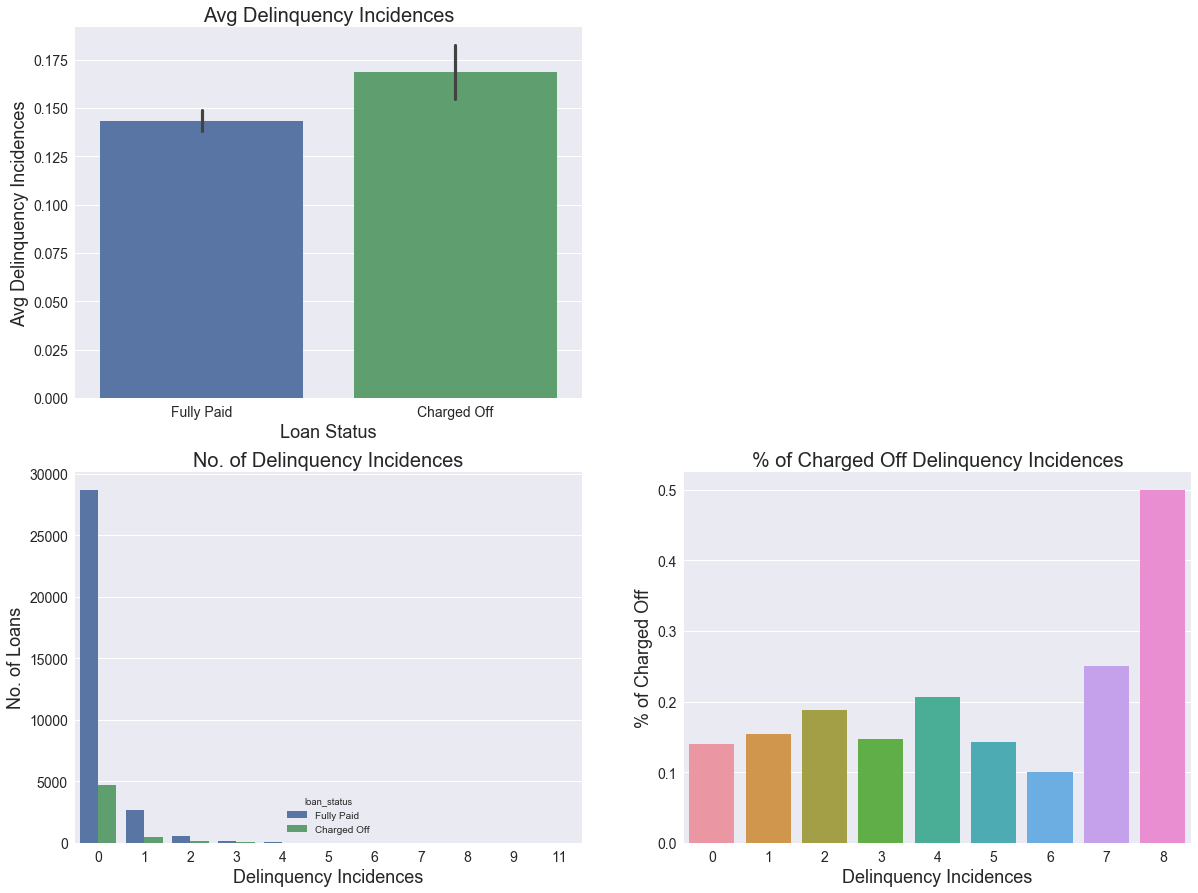

In [ ]:
plt.figure(figsize=[20,15])
plt.subplot(2,2,1)
createBarPlot('delinq_2yrs', 'Loan Status', 'Avg Delinquency Incidences', 'Avg Delinquency Incidences')
plt.subplot(2,2,3)
createCountPlot('delinq_2yrs', 'Delinquency Incidences', 'No. of Loans', 'No. of Delinquency Incidences')
plt.subplot(2,2,4)
charge_off_rates = loan.groupby('delinq_2yrs')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
createPercPlot('delinq_2yrs', 'Delinquency Incidences', '% of Charged Off', '% of Charged Off Delinquency Incidences')
plt.show()

### Conclusion: delinq_2yrs has little influence on loan_status due to lack of enough data on customers who have more than 5 deliquencies in last 2 years. This field will be dropped for further analysis.

### Univariate analysis for col: Number of inquiries in the last 6 months

In [ ]:
loan.inq_last_6mths.unique()

array([1, 5, 2, 3, 0, 4, 6, 7, 8], dtype=int64)

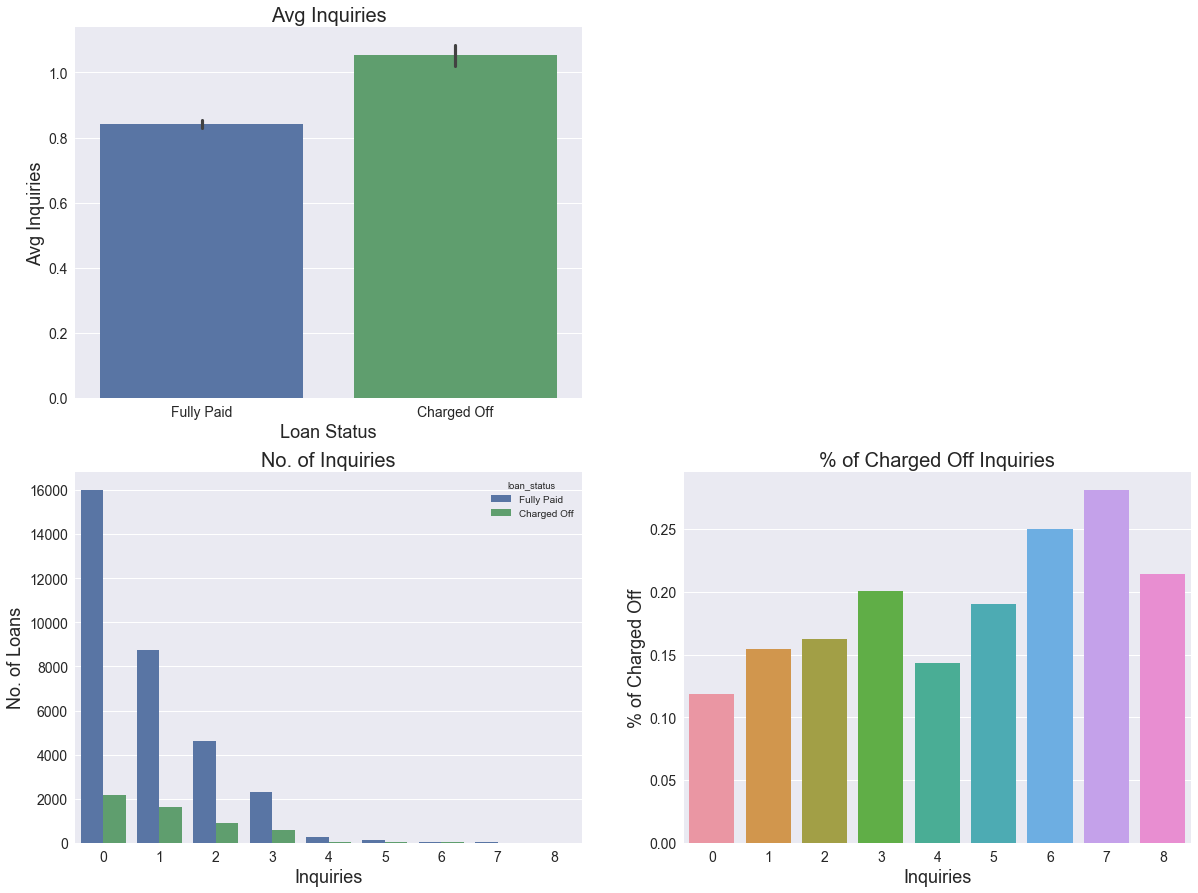

In [ ]:
plt.figure(figsize=[20,15])
plt.subplot(2,2,1)
createBarPlot('inq_last_6mths', 'Loan Status', 'Avg Inquiries', 'Avg Inquiries')
plt.subplot(2,2,3)
createCountPlot('inq_last_6mths', 'Inquiries', 'No. of Loans', 'No. of Inquiries')
plt.subplot(2,2,4)
createPercPlot('inq_last_6mths', 'Inquiries', '% of Charged Off', '% of Charged Off Inquiries')
plt.show()

### Conclusion: inq_last_6mnths has little influence on loan_status however, there is isn't data of customers who have had beyond 6 inquiries to consider this field as a key influencer

### Univariate analysis for col: open_acc(Number of open credit lines)

In [ ]:
loan.open_acc.unique()

array([ 3,  2, 10,  9,  7,  4, 11, 14, 12, 20,  8,  6, 15, 17,  5, 13, 16,
       30, 21, 18, 19, 27, 23, 34, 25, 22, 24, 26, 32, 28, 29, 33, 31, 39,
       35, 36, 38, 44, 41, 42], dtype=int64)

In [ ]:
def createDistPlot(varName, xLabel, yLabel, title):
    dist_plot = sns.distplot(loan[varName])
    setLabels(dist_plot, xLabel, yLabel, title)
    
def createBoxPlot(varName, xLabel, yLabel, title):
    box_plot = sns.boxplot(x=varName,y='loan_status',data=loan)
    setLabels(box_plot, xLabel, yLabel, title)

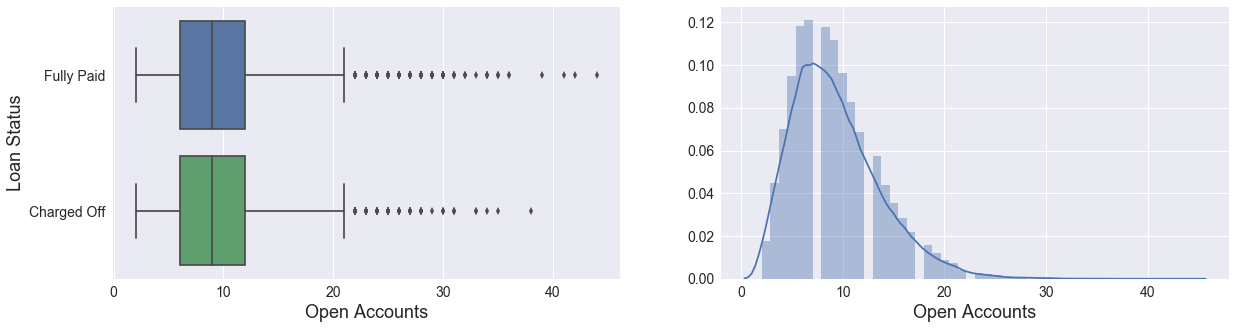

In [ ]:
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
createBoxPlot('open_acc', 'Open Accounts', 'Loan Status', '')

plt.subplot(1,2,2)
createDistPlot('open_acc', 'Open Accounts', '', '')

### Conclusion: open_acc is not influencer. Visualization above makes it evident.

### Univariate analysis for col: pub_rec (number of derogatory public records)

In [ ]:
loan.pub_rec.unique()
#len(loan.pub_rec[loan.pub_rec == 0])/len(loan)

array([0, 1, 2, 3, 4], dtype=int64)

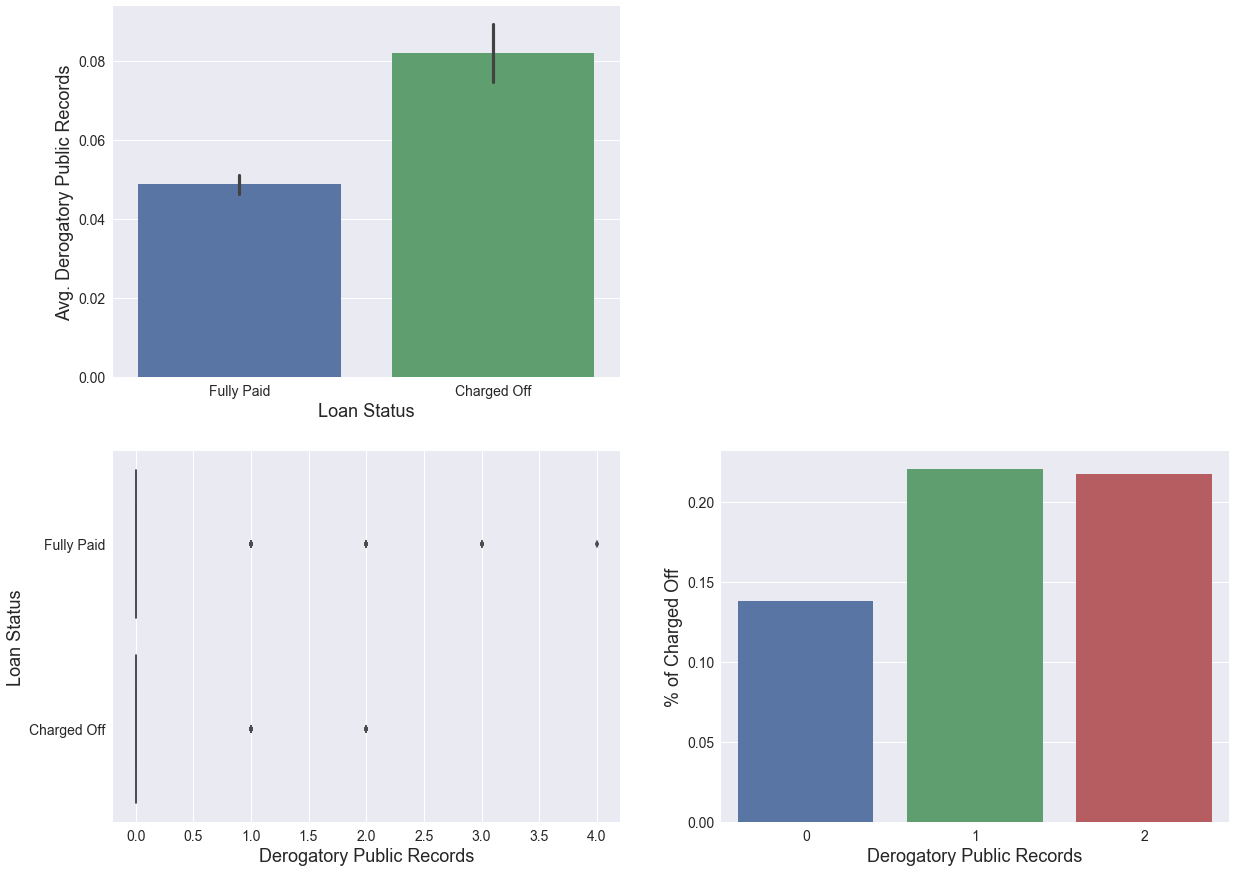

In [ ]:
plt.figure(figsize=[20,15])
plt.subplot(2,2,3)
createBoxPlot('pub_rec', 'Derogatory Public Records', 'Loan Status', '')
plt.subplot(2,2,1)
createBarPlot('pub_rec', 'Loan Status', 'Avg. Derogatory Public Records', '')
plt.subplot(2,2,4)
charge_off_rates = loan.groupby('pub_rec')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
createPercPlot('pub_rec', 'Derogatory Public Records', '% of Charged Off', '')

### Conclusion: pub_rec can't be considered as an influencer due to lack of enough evidence. About 95% of the customers have 0 pub_rec

### Univariate analysis for cols: loan_amnt, funded_amnt, funded_amnt_inv

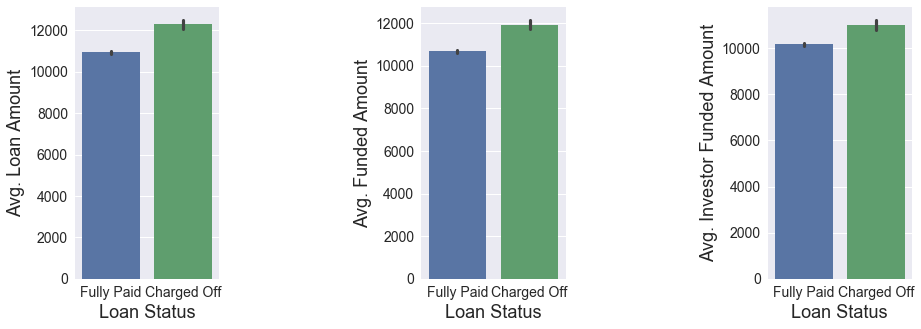

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(1,5,1)
createBarPlot('loan_amnt', 'Loan Status', 'Avg. Loan Amount', '')
plt.subplot(1,5,3)
createBarPlot('funded_amnt', 'Loan Status', 'Avg. Funded Amount', '')
plt.subplot(1,5,5)
createBarPlot('funded_amnt_inv', 'Loan Status', 'Avg. Investor Funded Amount', '')

### Conclusion: These fields are perfectly correlated(based on domain knowledge) and influence loan_status in similar way so only funded_amnt will be conisered for futher analysis and the rest will be dropped.

### Univariate analysis for col: term

In [ ]:
loan.term.unique()

array(['36 months', '60 months'], dtype=object)

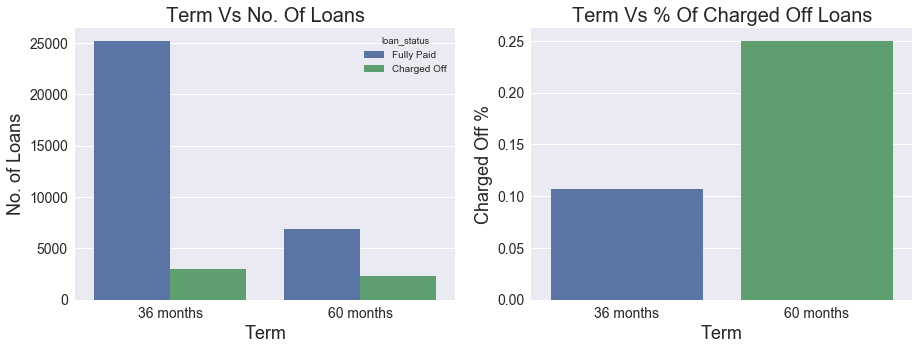

In [ ]:
termpercent = pd.DataFrame(loan[loan.loan_status == 'Charged Off']['term'].value_counts()/loan['term'].value_counts()).reset_index()
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
fig = sns.countplot('term',hue='loan_status',data=loan)
setLabels(fig, 'Term', 'No. of Loans', 'Term Vs No. Of Loans')

plt.subplot(1,2,2)
fig=sns.barplot(y='term',x='index',data=termpercent)
setLabels(fig, 'Term', 'Charged Off %', 'Term Vs % Of Charged Off Loans')
plt.show()

### Conclusion: Percentage of charged off customers are higher for 60 months (25%) than 36 months term (12%) so this is an influencer.

### Univariate analysis for col: int_rate

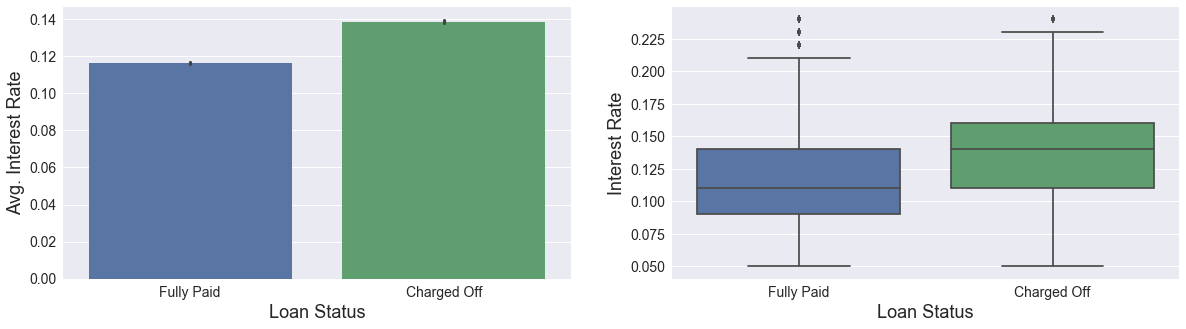

In [ ]:
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
fig = sns.barplot(y='int_rate',x='loan_status',data=loan)
setLabels(fig, 'Loan Status', 'Avg. Interest Rate', '')
plt.subplot(1,2,2)
fig = sns.boxplot(y='int_rate', x='loan_status', data=loan, order=['Fully Paid','Charged Off'])
setLabels(fig, 'Loan Status', 'Interest Rate', '')

### Conclusion: Charged Off customers pay a higher interest (about 2%) than the fully paid. This is an influencer however, will need to understand the domain better to understand whether banks charge higher interest to risky customers. In that case, this observation will not be a causation.

### Univariate analysis for col: grade

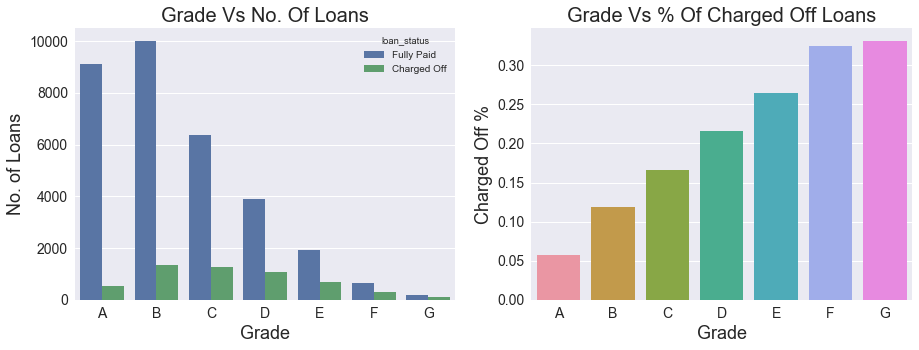

In [ ]:
gradepercent = pd.DataFrame(loan[loan.loan_status == 'Charged Off']['grade'].value_counts()/loan['grade'].value_counts()).reset_index()
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
fig = sns.countplot('grade',hue='loan_status',data=loan,order=['A','B','C','D','E','F','G'])
setLabels(fig, 'Grade', 'No. of Loans', 'Grade Vs No. Of Loans')
plt.subplot(1,2,2)
fig = sns.barplot(y='grade',x='index',data=gradepercent)
setLabels(fig, 'Grade', 'Charged Off %', 'Grade Vs % Of Charged Off Loans')
plt.show()

### Conclusion: Big influencer - Worse the grade, risky the customer.
### Grade D - 20% of charged off customers
### Grade E - 25% of charged of charged off customers
### Grade F&G - Above 30% of charged off customers

### Univariate analysis for col: sub_grade

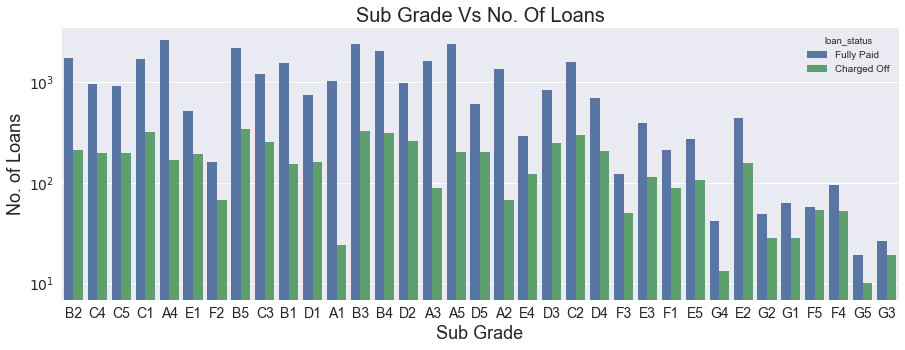

In [ ]:
plt.figure(figsize=[15,5])
fig = sns.countplot('sub_grade',hue='loan_status',data=loan, log=True)
setLabels(fig, 'Sub Grade', 'No. of Loans', 'Sub Grade Vs No. Of Loans')

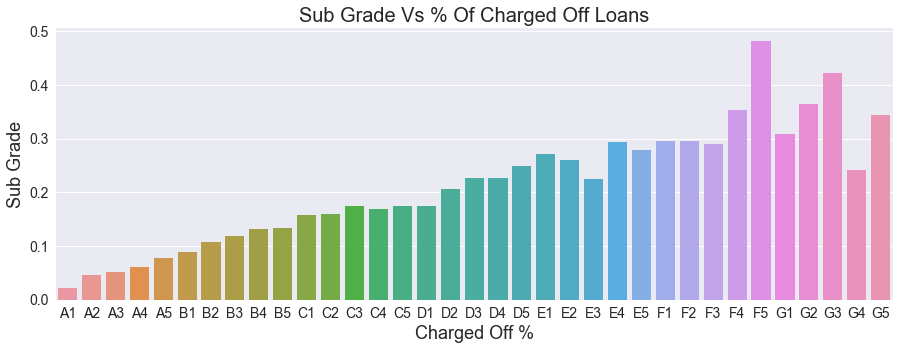

In [ ]:
sgradepercent = pd.DataFrame(loan[loan.loan_status == 'Charged Off']['sub_grade'].value_counts()/loan['sub_grade'].value_counts()).reset_index()
plt.figure(figsize=[15,5])
fig = sns.barplot(y='sub_grade',x='index',data=sgradepercent)
setLabels(fig, 'Charged Off %', 'Sub Grade', 'Sub Grade Vs % Of Charged Off Loans')
plt.show()

### Conclusion: Big influencer - Worse the sub_grade, risky the customer.
### Grade F5  >45% of charged off customers
### Grade G3 > 40% of charged off customers
### Grade F4 & G5 > 35% of charged off customers

### emp_length and home_ownership do not influence loan_status. The below visualizations make the conclusion evident.

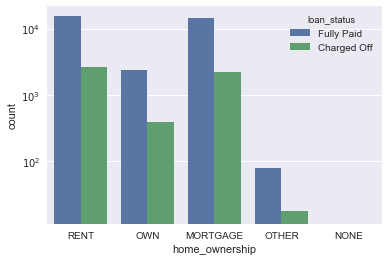

In [ ]:
sns.countplot('home_ownership', hue='loan_status', data=loan, log=True)
plt.show()

### The ratio of charged_off and fully paid remains constant across all home_ownership types so this column is not an influencer

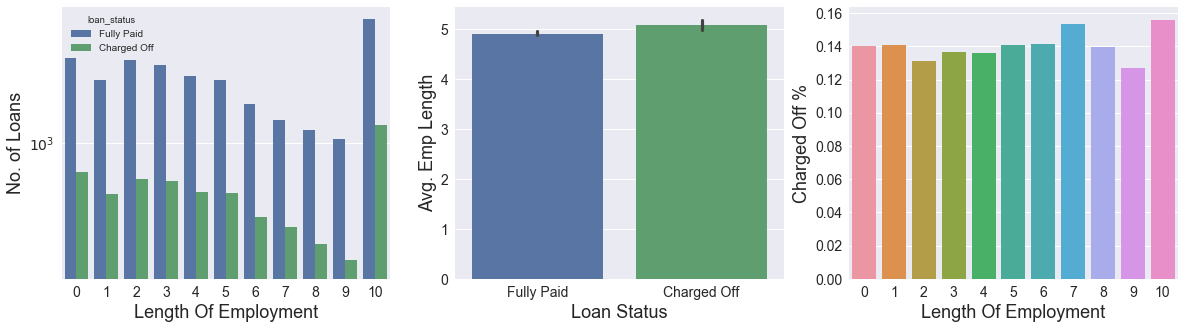

In [ ]:
#sns.barplot(y='emp_length',x='loan_status',data=loan)
plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
fig = sns.countplot('emp_length', hue='loan_status',data=loan,log=True)
setLabels(fig, 'Length Of Employment', 'No. of Loans', '')
plt.subplot(1,3,2)
fig = sns.barplot(y='emp_length', x='loan_status', data=loan)
setLabels(fig, 'Loan Status', 'Avg. Emp Length', '')
plt.subplot(1,3,3)
charge_off_rates = loan.groupby('emp_length')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
fig = sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values)
setLabels(fig, 'Length Of Employment', 'Charged Off %', '')
plt.show()

### Univariate analysis of col: Purpose

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

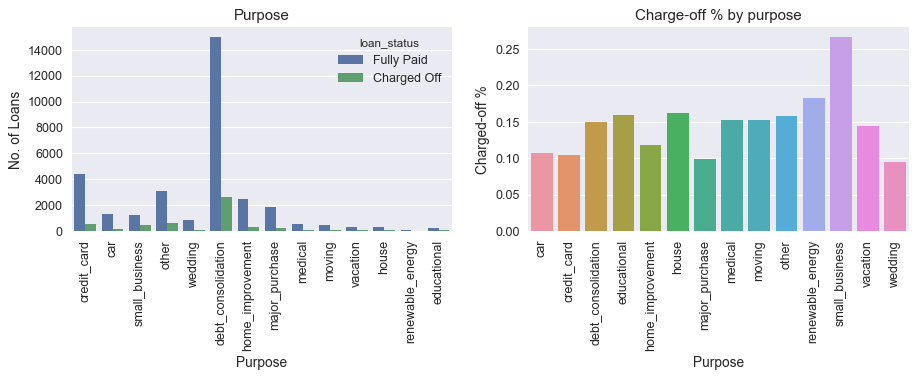

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.countplot('purpose',hue='loan_status',data=loan,ax=ax1)
ax1.set_xlabel('Purpose')
ax1.set_ylabel('No. of Loans')
ax1.set_title('Purpose')
charge_off_rates =loan.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, ax=ax2)
ax2.set_xlabel('Purpose')
ax2.set_ylabel('Charged-off %')
ax2.set_title('Charge-off % by purpose')
plt.sca(ax1)
plt.xticks(rotation=90)
plt.sca(ax2)
plt.xticks(rotation=90)

**Notice that only 9% of completed loans for weddings have charged-off, but 26% of completed small business loans have charged-off.**

### Univariate analysis of col: revol_util

In [ ]:
loan['revol_util'].describe()

count    37476.000000
mean         0.488628
std          0.283264
min          0.000000
25%          0.260000
50%          0.490000
75%          0.720000
max          1.000000
Name: revol_util, dtype: float64

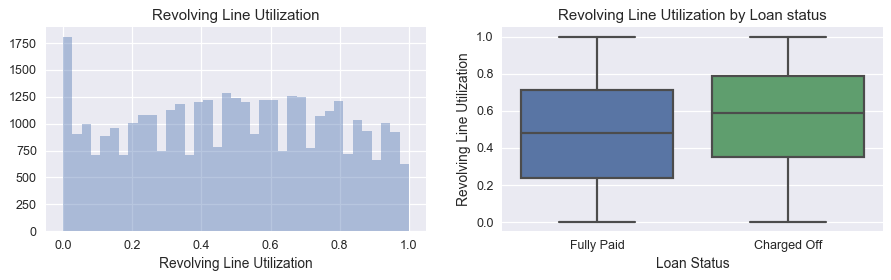

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(loan['revol_util'], kde=False, ax=ax1)
ax1.set_xlabel('Revolving Line Utilization')
ax1.set_title('Revolving Line Utilization')
sns.boxplot(y='revol_util', x='loan_status', data=loan, ax=ax2, order=['Fully Paid','Charged Off'])
ax2.set_xlabel('Loan Status')
ax2.set_ylabel('Revolving Line Utilization')
ax2.set_title('Revolving Line Utilization by Loan status')

**There is noticeable difference between Fully Paid and Charged Off. <BR>
Borrowers who are charged-off tend to have higher Revolving Line Utilization.**

### Univariate analysis of col: addr_state

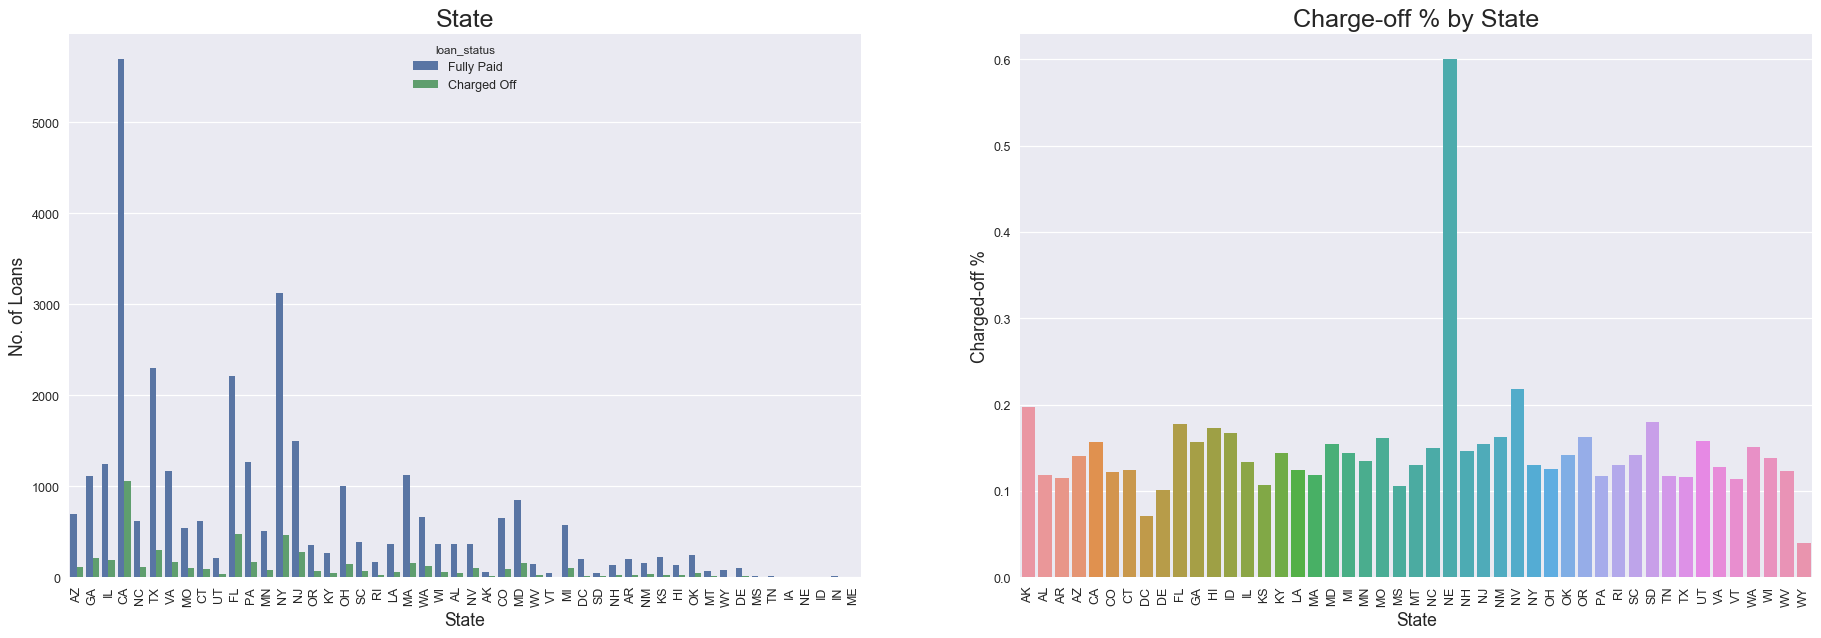

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8), dpi=90)
sns.countplot('addr_state',hue='loan_status',data=loan,ax=ax1)
ax1.set_xlabel('State', fontsize=14)
ax1.set_ylabel('No. of Loans', fontsize=14)
ax1.set_title('State', fontsize=20)
charge_off_rates = loan.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, ax=ax2)
ax2.set_xlabel('State', fontsize=14)
ax2.set_ylabel('Charged-off %', fontsize=14)
ax2.set_title('Charge-off % by State', fontsize=20)
plt.sca(ax1)
plt.xticks(rotation=90)
plt.sca(ax2)
plt.xticks(rotation=90)
plt.show()

In [ ]:
data_map=pd.DataFrame(loan.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']).reset_index()

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

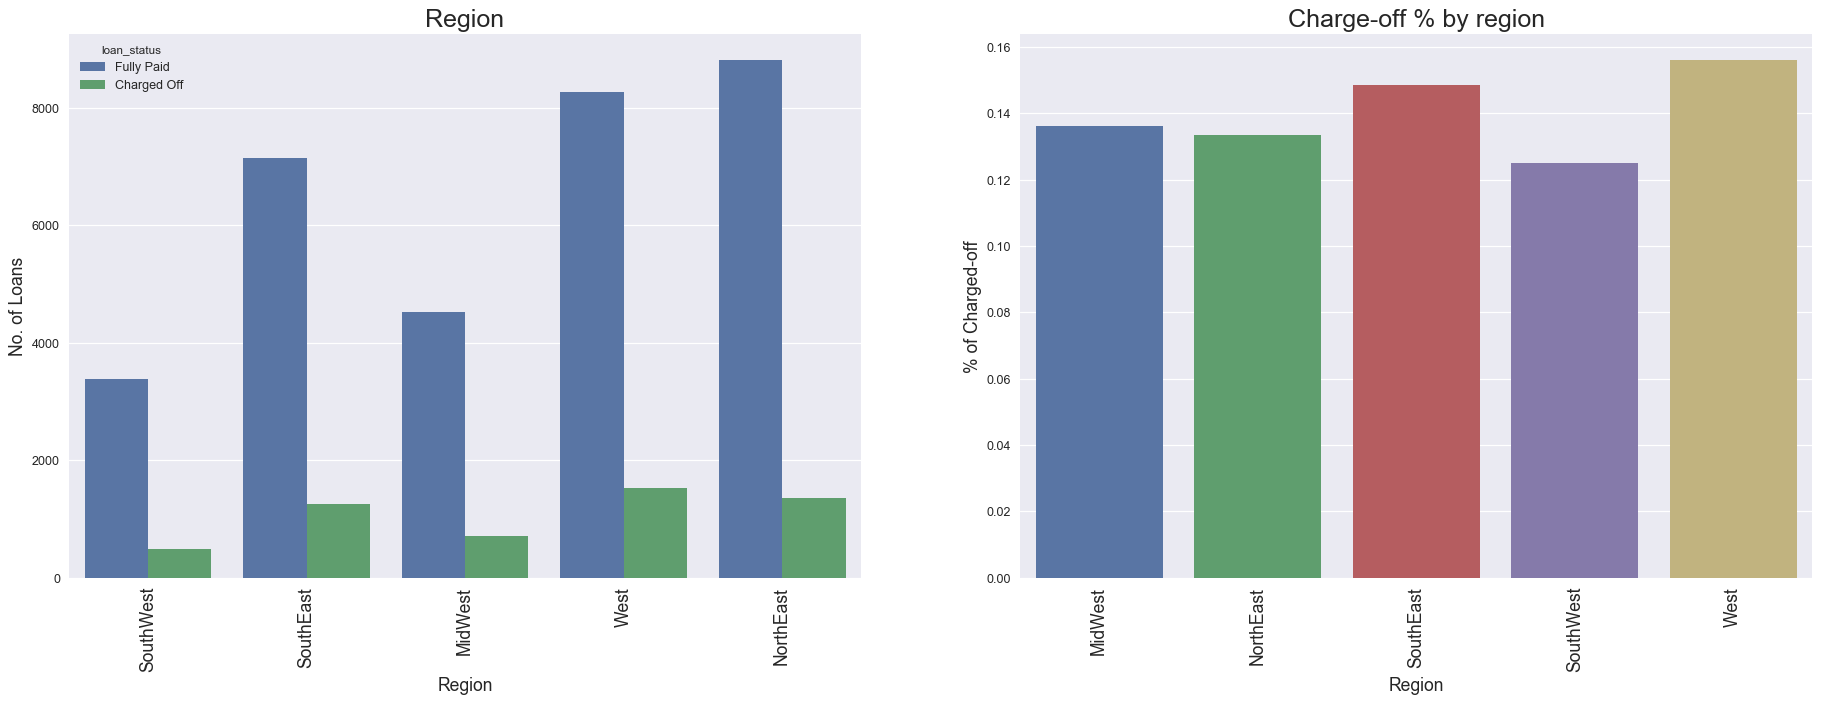

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8), dpi=90)
sns.countplot('region',hue='loan_status',data=loan,ax=ax1)
ax1.set_xlabel('Region', fontsize=14)
ax1.set_ylabel('No. of Loans', fontsize=14)
ax1.set_title('Region', fontsize=20)
charge_off_rates = loan.groupby('region')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, ax=ax2)
ax2.set_xlabel('Region', fontsize=14)
ax2.set_ylabel('% of Charged-off', fontsize=14)
ax2.set_title('Charge-off % by region', fontsize=20)
plt.sca(ax1)
plt.xticks(rotation=90, fontsize=14)
plt.sca(ax2)
plt.xticks(rotation=90, fontsize=14)

**The regions of the West and SouthEast had a higher percentage in the Charged off.**

Go to: [Top](#top) <BR>
Go to: [Bivarite Analysis](#bivariate_analysis)    `
<a id = 'univariate_non_influencers' />

## 3.b. Univariate Analysis for Non-Influencers: 
## Analysis of the columns that are not the influencers of loan_status and the insights on reasons they have been dropped are given below.

### Univariate analysis of column: total_rec_prncp

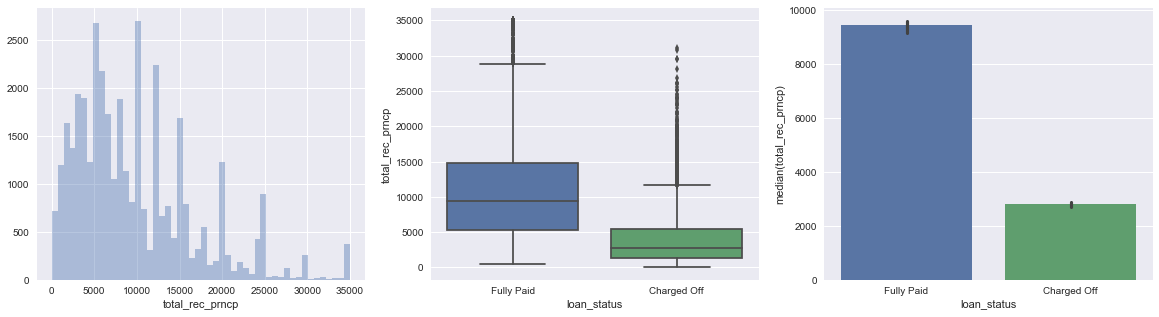

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.distplot(loan['total_rec_prncp'], kde=False)
plt.subplot(1, 3, 2)
sns.boxplot(x='loan_status', y='total_rec_prncp', data=loan)
plt.subplot(1, 3, 3)
sns.barplot(x='loan_status', y='total_rec_prncp', data=loan, estimator=np.median)
plt.show()

**Intution: From the above code, the total_rec_prncp is higher for the loans that are paid off and not for the charged off. Hence the total_rec_princ will always be less for the defaulters. However, the bank will know its effect only after it issues a loan to a customer.**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis of  Col: recoveries

In [ ]:
print(loan['recoveries'].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,1]))
recoveries_085 = loan.loc[loan['recoveries'] <= loan.recoveries.quantile(0.85)]

count    37476.000000
mean        97.515388
std        701.050309
min          0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
75%          0.000000
80%          0.000000
85%          0.000000
90%         14.395000
100%     29623.350000
max      29623.350000
Name: recoveries, dtype: float64


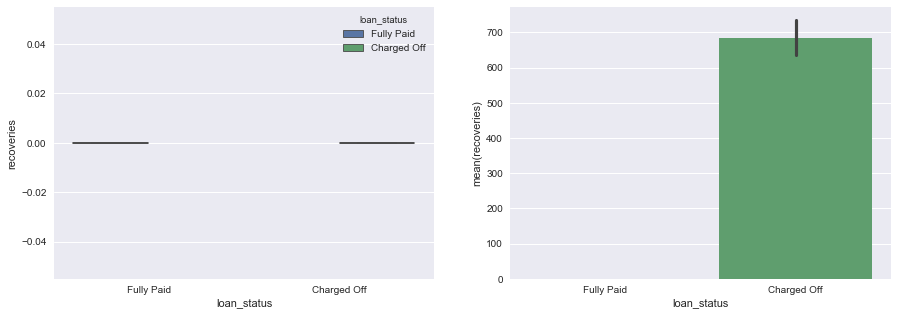

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='loan_status', y='recoveries', hue= 'loan_status', data=recoveries_085)
# plt.yscale('log')

plt.subplot(1, 2, 2)
# sns.barplot(x='loan_status', y='recoveries', hue="loan_status", data=data, estimator=np.sum)
plt.subplot(1,2,2)
sns.barplot(y='recoveries', x='loan_status',data=loan)

plt.show()

**Intution: Although,the aforedisplayed boxplots show that there is no difference in the recoveries being made for the 'Charged off' vs 'Fully Paid'. However, the barplot shows that mostly recoveries have happened to the loans that have been defaulted.**<BR><BR> **But, recoveries can happen only after a loan has been issued to a customer. Hence, this doesn't influence a desicion on whether bank must issue a loan or not.**<BR> Hence, this column can be removed from the dataset.

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis of col: last_pymnt_d

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

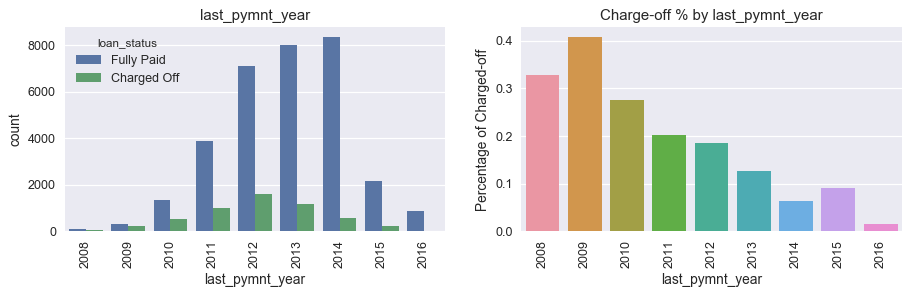

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.countplot('last_pymnt_year',hue='loan_status',data=loan,ax=ax1)
ax1.set_xlabel('last_pymnt_year')
ax1.set_title('last_pymnt_year')
charge_off_rates = loan.groupby('last_pymnt_year')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, ax=ax2)
ax2.set_xlabel('last_pymnt_year')
ax2.set_ylabel('Percentage of Charged-off')
ax2.set_title('Charge-off % by last_pymnt_year')
plt.sca(ax1)
plt.xticks(rotation=90)
plt.sca(ax2)
plt.xticks(rotation=90)

**Intution: The count plot shows that the last month payments recevied for both Charged Off and Fully Paid. The bar plot shows that the percentage of payments recevied are almost the same for both the status types. Hence can be discarded for its not influencing the loan being led to get default.**

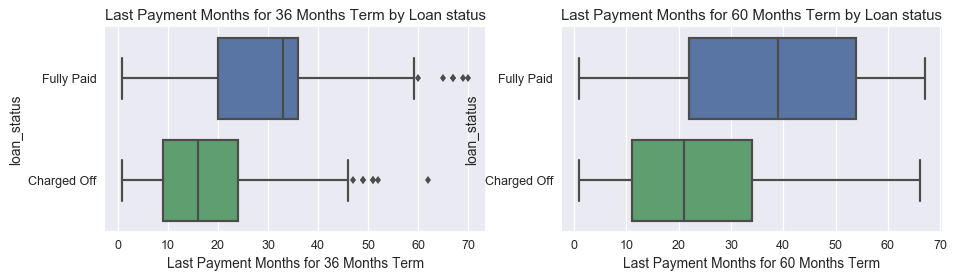

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.boxplot(x='last_pymnt_months', y='loan_status', data=loan[loan['term']=='36 months'], ax=ax1, order=['Fully Paid','Charged Off'])
ax1.set_xlabel('Last Payment Months for 36 Months Term')
ax1.set_title('Last Payment Months for 36 Months Term by Loan status')
sns.boxplot(x='last_pymnt_months', y='loan_status', data=loan[loan['term']=='60 months'], ax=ax2, order=['Fully Paid','Charged Off'])
ax2.set_xlabel('Last Payment Months for 60 Months Term')
ax2.set_title('Last Payment Months for 60 Months Term by Loan status')

* Last payment of Charged off loans is around 16 Months for 36 Terms loans
* Last payment of Charged off loans is around 21 Months for 60 Terms loans

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis for col: last_credit_pull_d

(array([0, 1]), <a list of 2 Text xticklabel objects>)

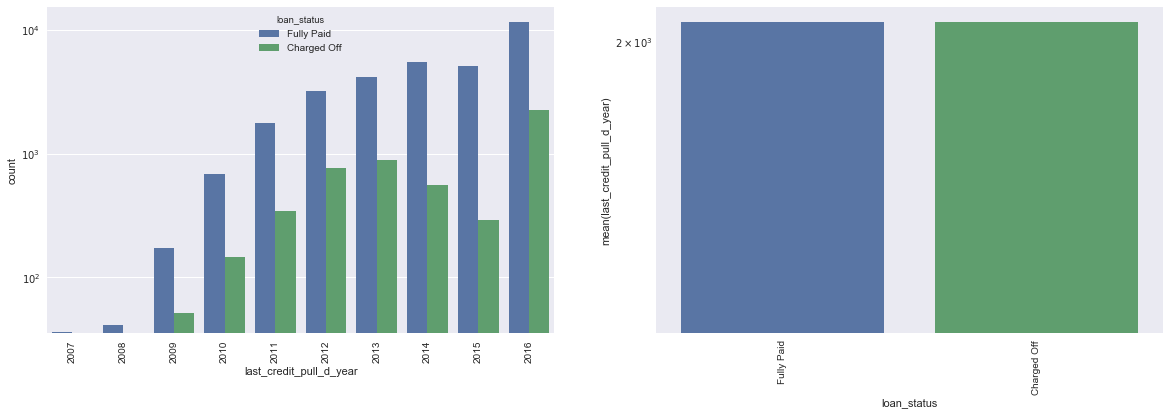

In [ ]:
loan['last_credit_pull_d']=pd.to_datetime(loan['last_credit_pull_d'],format='%b-%y')
loan['last_credit_pull_d_year'] = pd.DatetimeIndex(loan['last_credit_pull_d']).year
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='last_credit_pull_d_year',hue='loan_status',data=loan, log=True)
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2)
sns.barplot(y='last_credit_pull_d_year',x='loan_status',data=loan, log=True)
plt.xticks(rotation = 90)

**Intution: The count plot shows that the most recent month/year's LC pulled credit are more in number for the Charged off in the years 2012, 2013, and 2016. However,the bar plot shows that the # of recent payments recevied are for the 'Charged Off'.So this could be a marginal influencer.** <BR><BR> **The bank must first look into other infuencers like the customers grade/term/dti/purpose using which it can infer, if the customer defaults the loan, what would be the maximum years it can expect the customer to start repaying.**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis for col: collection_recovery_fee

In [ ]:
print(loan['collection_recovery_fee'].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,1]))
rec_fees_90 = loan.loc[loan['collection_recovery_fee'] <= loan.collection_recovery_fee.quantile(0.9)]

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='collection_recovery_fee',hue='loan_status',data=rec_fees_90, log=True)
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2)
sns.barplot(y='collection_recovery_fee',x='loan_status',data=rec_fees_90, log=True)
plt.xticks(rotation = 90)

"print(loan['collection_recovery_fee'].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,1]))\nrec_fees_90 = loan.loc[loan['collection_recovery_fee'] <= loan.collection_recovery_fee.quantile(0.9)]\n\nplt.figure(figsize=(20, 6))\nplt.subplot(1, 2, 1)\nsns.countplot(x='collection_recovery_fee',hue='loan_status',data=rec_fees_90, log=True)\nplt.xticks(rotation = 90)\n\nplt.subplot(1, 2, 2)\nsns.barplot(y='collection_recovery_fee',x='loan_status',data=rec_fees_90, log=True)\nplt.xticks(rotation = 90)"

**Intution: The barplot on the right side shows that neither there are  collection_recovery_fees for 'Fully Paid' not the 'Charged Off'. Hence this column doesn't effect the loan status and can be removed.**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis for col: last_pymnt_amnt

count    25482.000000
mean      1463.048284
std       1610.187488
min        160.470000
10%        211.840000
20%        276.520000
30%        349.716000
40%        449.970000
50%        617.290000
60%        943.548000
70%       1754.716000
75%       2261.925000
80%       2814.080000
85%       3458.379500
90%       4205.788000
100%      6244.270000
max       6244.270000
Name: last_pymnt_amnt, dtype: float64


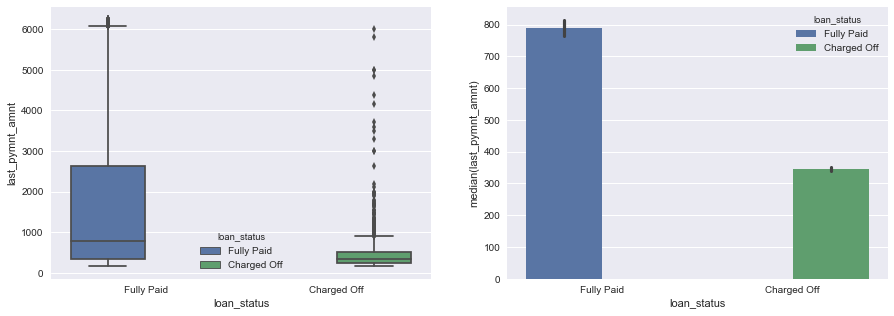

In [ ]:
last_pymnt_amnt_90 = loan.loc[loan['last_pymnt_amnt'] <= loan.last_pymnt_amnt.quantile(0.85)]
last_pymnt_amnt_90 = last_pymnt_amnt_90.loc[last_pymnt_amnt_90['last_pymnt_amnt'] > last_pymnt_amnt_90.last_pymnt_amnt.quantile(0.2)]
print(last_pymnt_amnt_90['last_pymnt_amnt'].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,1]))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='loan_status', y='last_pymnt_amnt', hue= 'loan_status', data=last_pymnt_amnt_90)

plt.subplot(1, 2, 2)
sns.barplot(x='loan_status', y='last_pymnt_amnt', hue="loan_status", data=last_pymnt_amnt_90, estimator=np.median)
plt.show()

**Intution: The boxplot and barplot depicts that last payment amount received is always higher for the Fully paid loans than that of Charged Off(Certainly, the customers that are defaulted for the couldnt pay the payment or paid very less, in first place. Hence this column doesn't effect the loan status and can be removed.**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis of col: pub_rec_bankruptcies

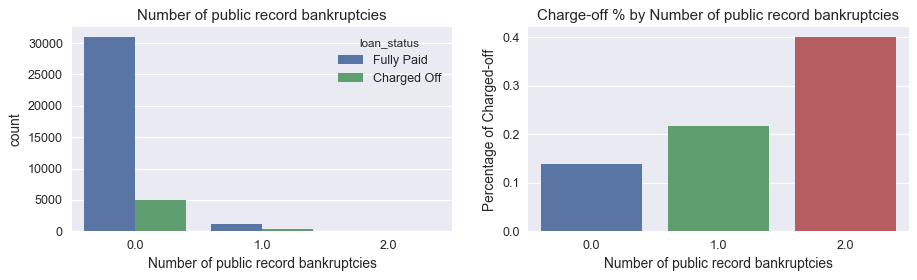

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.countplot('pub_rec_bankruptcies',hue='loan_status',data=loan,ax=ax1)
ax1.set_xlabel('Number of public record bankruptcies')
ax1.set_title('Number of public record bankruptcies')
charge_off_rates = loan.groupby('pub_rec_bankruptcies')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, ax=ax2)
ax2.set_xlabel('Number of public record bankruptcies')
ax2.set_ylabel('Percentage of Charged-off')
ax2.set_title('Charge-off % by Number of public record bankruptcies')

**Higher the Number of public record bankruptcies higher the chances of charge-off**

**But there are very few loans for 1 & 2 public record bankruptcies. Hence this can be removed.**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis of col: revol_bal

In [ ]:
loan['revol_bal'].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98,0.99])

count     37476.000000
mean      13375.792534
std       15902.729569
min           0.000000
10%        1118.000000
20%        2823.000000
30%        4635.000000
40%        6604.000000
50%        8852.500000
60%       11500.000000
70%       14834.500000
80%       19713.000000
90%       29126.500000
95%       41619.500000
98%       63633.500000
99%       83326.750000
max      149588.000000
Name: revol_bal, dtype: float64

There is huge difference between mean and median
We can remove outliers after 99% percentiles and retain before.

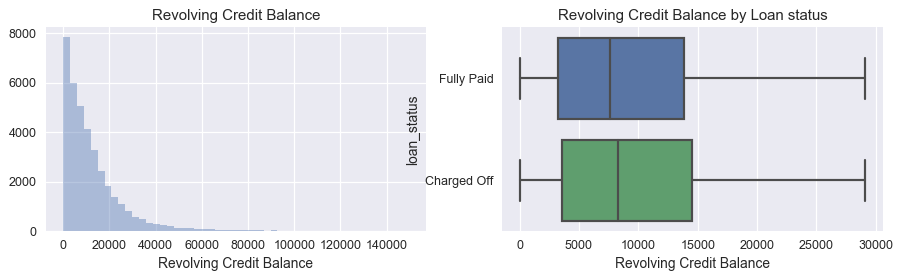

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(loan['revol_bal'], kde=False, ax=ax1)
ax1.set_xlabel('Revolving Credit Balance')
ax1.set_title('Revolving Credit Balance')
sns.boxplot(x='revol_bal', y='loan_status', data=loan[loan['revol_bal']<=loan.revol_bal.quantile(0.9)], ax=ax2, order=['Fully Paid','Charged Off'])
ax2.set_xlabel('Revolving Credit Balance')
ax2.set_title('Revolving Credit Balance by Loan status')

**There isn't a large difference in the means. Hence this can be removed.**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis of col: total_acc

In [ ]:
loan['total_acc'].describe()

count    37476.000000
mean        22.094487
std         11.415737
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64

No large difference between Mean and Median

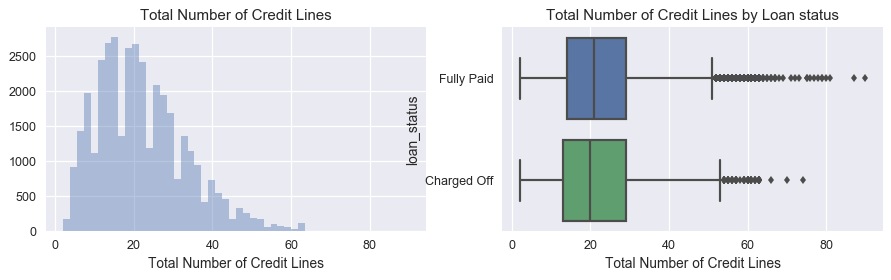

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(loan['total_acc'], kde=False, ax=ax1)
ax1.set_xlabel('Total Number of Credit Lines')
ax1.set_title('Total Number of Credit Lines')
sns.boxplot(x='total_acc', y='loan_status', data=loan, ax=ax2, order=['Fully Paid','Charged Off'])
ax2.set_xlabel('Total Number of Credit Lines')
ax2.set_title('Total Number of Credit Lines by Loan status')

**No large differences here. Hence this can be removed.**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis of cols: total_pymnt, total_pymnt_inv and total_rec_prncp

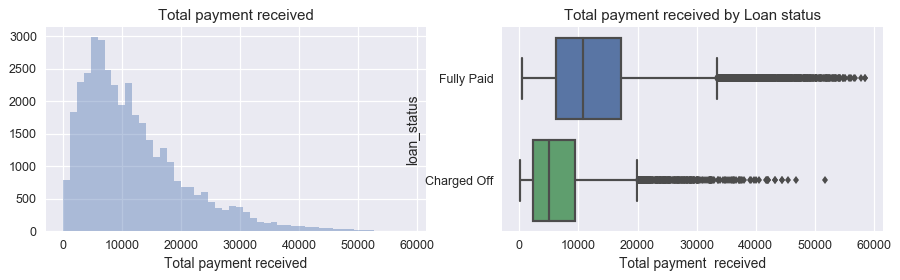

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(loan['total_pymnt'], kde=False, ax=ax1)
ax1.set_xlabel('Total payment received')
ax1.set_title('Total payment received')
sns.boxplot(x='total_pymnt', y='loan_status', data=loan, ax=ax2, order=['Fully Paid','Charged Off'])
ax2.set_xlabel('Total payment  received')
ax2.set_title('Total payment received by Loan status')

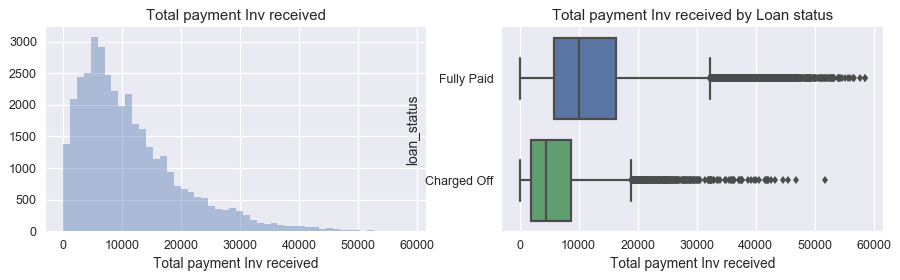

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(loan['total_pymnt_inv'], kde=False, ax=ax1)
ax1.set_xlabel('Total payment Inv received')
ax1.set_title('Total payment Inv received')
sns.boxplot(x='total_pymnt_inv', y='loan_status', data=loan, ax=ax2, order=['Fully Paid','Charged Off'])
ax2.set_xlabel('Total payment Inv received')
ax2.set_title('Total payment Inv received by Loan status')

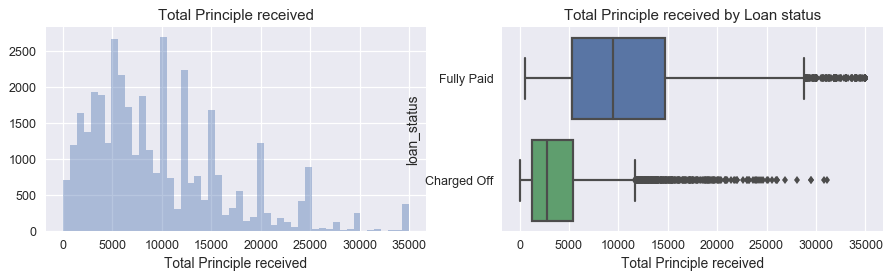

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(loan['total_rec_prncp'], kde=False, ax=ax1)
ax1.set_xlabel('Total Principle received')
ax1.set_title('Total Principle received')
sns.boxplot(x='total_rec_prncp', y='loan_status', data=loan, ax=ax2, order=['Fully Paid','Charged Off'])
ax2.set_xlabel('Total Principle received')
ax2.set_title('Total Principle received by Loan status')

**Borrowers who are charged-off tend to have lesser Payment & Principal received. Hence this can be remove these columns**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis of cols: total_rec_int 

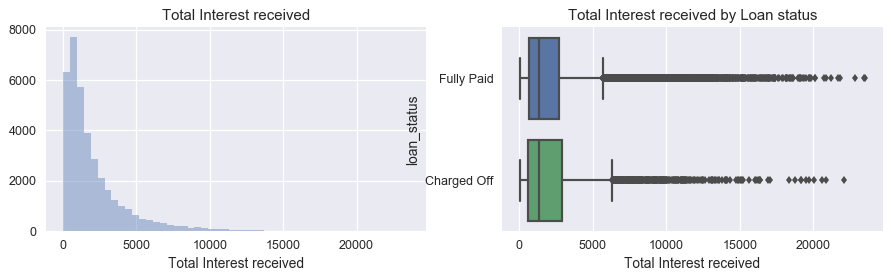

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(loan['total_rec_int'], kde=False, ax=ax1)
ax1.set_xlabel('Total Interest received')
ax1.set_title('Total Interest received')
sns.boxplot(x='total_rec_int', y='loan_status', data=loan, ax=ax2, order=['Fully Paid','Charged Off'])
ax2.set_xlabel('Total Interest received')
ax2.set_title('Total Interest received by Loan status')

**There is no large difference. Hence can be removed.**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

### Univariate analysis of col: total_rec_late_fee

In [ ]:
loan['total_rec_late_fee'].describe()

count    37476.000000
mean         1.381482
std          7.366722
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        180.200000
Name: total_rec_late_fee, dtype: float64

In [ ]:
loan.loc[loan['total_rec_late_fee'] == 0, 'total_rec_late_fee_range'] = '0'
loan.loc[loan['total_rec_late_fee'] > 0, 'total_rec_late_fee_range'] = 'Greater than 0'

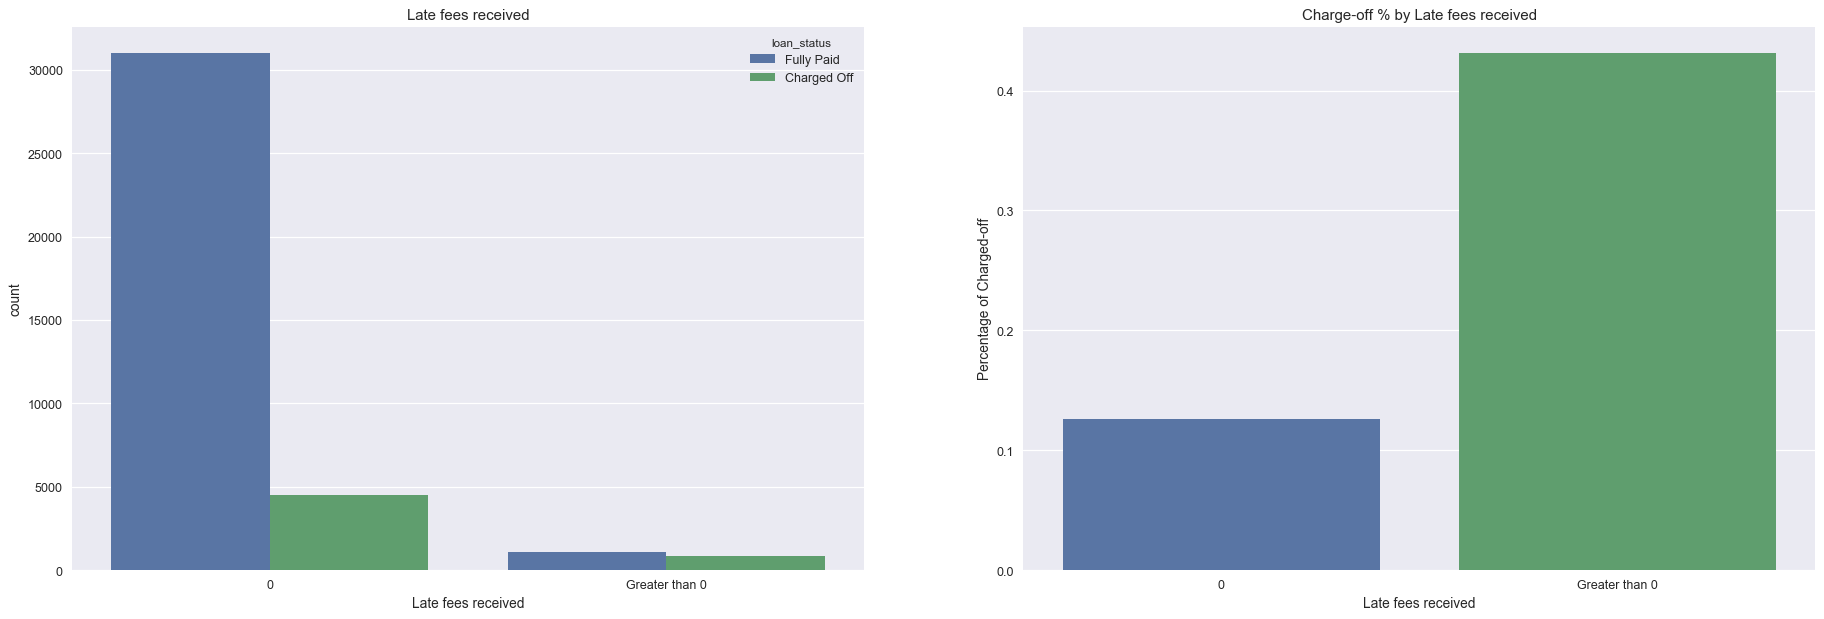

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8), dpi=90)
sns.countplot('total_rec_late_fee_range',hue='loan_status',data=loan,ax=ax1)
ax1.set_xlabel('Late fees received')
ax1.set_title('Late fees received')
charge_off_rates = loan.groupby('total_rec_late_fee_range')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, ax=ax2)
ax2.set_xlabel('Late fees received')
ax2.set_ylabel('Percentage of Charged-off')
ax2.set_title('Charge-off % by Late fees received')

**It is obvious that If Late fees received is more than 0 then higher the chances of charged off. Hence we can remove this column**

Go to: [Summary Of Univariate Analysis](#summary_univariate_analysis)<BR>
Go to: [Bivariate Analysis](#bivariate_analysis)

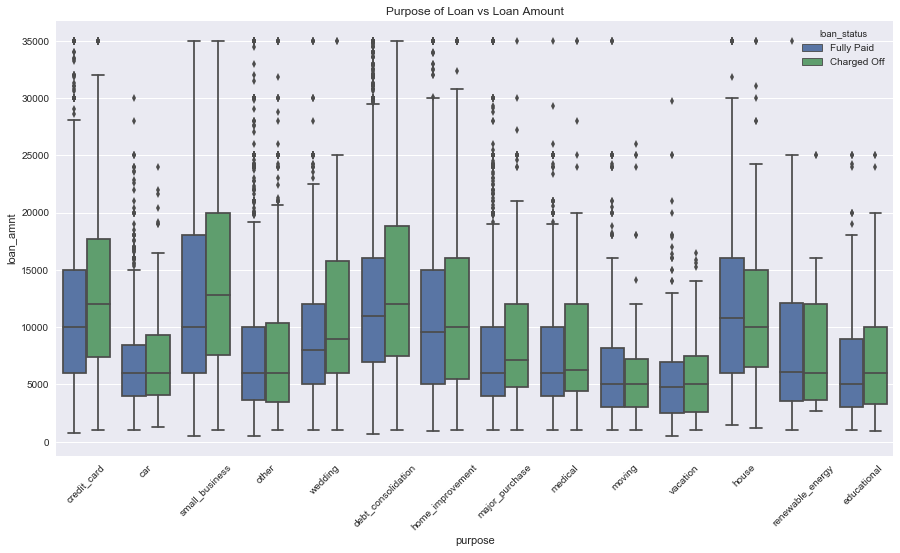

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data =loan, x='purpose', y='loan_amnt', hue ='loan_status')
plt.title('Purpose of Loan vs Loan Amount')
plt.xticks(rotation = 45)
plt.show()

Go to: [Top](#top) <BR>
Go to: [Summary of Univariate Analysis](#summary_univariate_analysis)<BR>
<a id='segmented_univariate_analysis' />

## 3.d: <u>Summary of Univariate:</u><BR><BR> As a result of univariate analysis, following columns have been identified as influencers of loan_status

### 1. sub_grade
### 2. grade
### 3. purpose
### 4. term
### 5. dti
### 6. int_rate
### 7. revol_util <BR><BR>

Go to: [Top](#top) <BR>
Go to: [Univariate Analysis](#univariate)    
Go to: [Summary of Univariate Analysis](#summary_univariate_analysis)
<a id='bivariate_analysis' /> <BR>

***

In [ ]:
loan_co = loan[loan['loan_status'] == 'Charged Off']
total_loss = loan_co['loan_amnt'].sum()
loan_co
loan_co_grp = loan_co.pivot_table(index='emp_title', values='loan_amnt', aggfunc='sum').reset_index().sort_values(by='loan_amnt', ascending=False)
loan_co_grp['loss_perc'] = loan_co_grp['loan_amnt']/total_loss * 100
loan_co_grp

emp_title  loan_amnt  loss_perc
4037                              unknown    3278525   5.003302
4052                              us army     492875   0.752168
367                       bank of america     292675   0.446646
4046                                  ups     263550   0.402199
4079                    us postal service     211150   0.322232
3402                        self employed     203400   0.310405
310                                  at&t     202975   0.309757
4199                              walmart     195025   0.297624
4094                                 usps     185500   0.283088
1127                department of defense     139675   0.213156
4140                     verizon wireless     129350   0.197399
1887                                  ibm     125900   0.192134
2559                       morgan stanley     124400   0.189845
2066                      jp morgan chase     115900   0.176873
4193                             wal mart     114825   0.175233
2733                     northrop grumman     104475   0.159438
2091                    kaiser permanente     103000   0.157187
4057                              us bank     102950   0.157110
4135                              verizon      97000   0.148030
4195                           walgreenss      93950   0.143376
3399                                 self      91900   0.140247
4108                   uss postal service      91500   0.139637
4234                          wells fargo      89075   0.135936
2325                                macys      88175   0.134562
2242               level 3 communications      88000   0.134295
4000                united parcel service      87000   0.132769
3210                              retired      80475   0.122812
932                               comcast      80450   0.122773
4236                     wells fargo bank      79750   0.121705
3742                               target      78400   0.119645
...                                   ...        ...        ...
329                           audio links       1200   0.001831
1305        emeritus at ridgewood gardens       1200   0.001831
1669                      grenoindustries       1200   0.001831
2463  metrowater reclamation dist chicago       1200   0.001831
270                                ariens       1100   0.001679
1709              han juven corr facility       1050   0.001602
4341                                yesco       1000   0.001526
1351              excalibur data recovery       1000   0.001526
1100          de la rue north america inc       1000   0.001526
122                aj industries west inc       1000   0.001526
2477                  michigan brewing co       1000   0.001526
2377     maryland division of corrections       1000   0.001526
1850                                   hp       1000   0.001526
3012                      pjr enterprises       1000   0.001526
1427                ferrell duncan clinic       1000   0.001526
47    absolute rehab and physical therapy       1000   0.001526
3951                      tyson foods inc       1000   0.001526
2233                legitime technologies       1000   0.001526
2754                npc international inc       1000   0.001526
2785                         oce business       1000   0.001526
1969              invision power services       1000   0.001526
2810                      omega home care       1000   0.001526
4285                wilson county schools       1000   0.001526
3868                          tim hortons       1000   0.001526
211   american national insurance company       1000   0.001526
3126                        quality glass       1000   0.001526
2131                         kidz express       1000   0.001526
258                            arc fresno       1000   0.001526
3677               stream global services       1000   0.001526
1441                       firehouse subs        900   0.001373

[4357 rows x 3 columns]

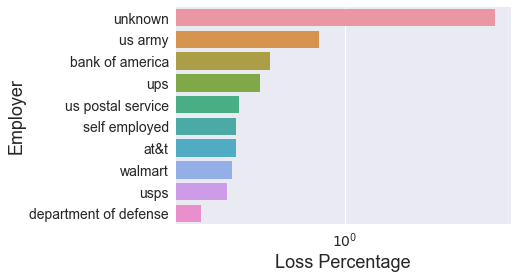

In [ ]:
fig = sns.barplot(y='emp_title', x='loss_perc', data=loan_co_grp[0:10], log=True)
setLabels(fig, 'Loss Percentage', 'Employer', '')
plt.show()

# 4. Bivariate analysis

**Lets get rid of the columns that are not the influencers after the Univariate analysis results.**

In [ ]:
print(len(list(loan)))
loan.drop(['recoveries',
           'collection_recovery_fee',
           'pub_rec_bankruptcies',
           'emp_length',
           'verification_status',
           'inq_last_6mths',
           'last_credit_pull_d_year'],axis=1,inplace=True)
print(len(list(loan)))

53
46


Go to: [Top](#top) <BR>
Go to: [4.b Bivariate analysis of Numerical variables](#bivariate_categorical) <BR>
Go to: [4.c Bivariate analysis of Categorical variables](#bivariate_categorical) <BR>
<a id='corr_matrix' />

### 4.a: Correlation matrix:

## Extracting the numerical variables and finding the correlation matrix.

In [ ]:
loan_correlation = loan.select_dtypes(exclude=["object"]).corr()
loan_correlation

id  loan_amnt  funded_amnt  funded_amnt_inv  \
id                  1.000000   0.125461     0.136110         0.238031   
loan_amnt           0.125461   1.000000     0.981563         0.936975   
funded_amnt         0.136110   0.981563     1.000000         0.955463   
funded_amnt_inv     0.238031   0.936975     0.955463         1.000000   
int_rate            0.056113   0.299714     0.303421         0.296300   
installment         0.080001   0.931591     0.957683         0.904223   
annual_inc          0.009090   0.266071     0.261758         0.249095   
dti                 0.091339   0.061553     0.061421         0.070142   
delinq_2yrs        -0.008148  -0.033472    -0.033572        -0.039830   
open_acc            0.018254   0.173496     0.172041         0.159118   
pub_rec            -0.019738  -0.046050    -0.046572        -0.048136   
revol_bal           0.001720   0.313298     0.306032         0.285638   
revol_util          0.093618   0.062612     0.066716         0.072076   
total_acc           0.041120   0.255260     0.249532         0.241886   
total_pymnt         0.115040   0.882873     0.900029         0.874970   
total_pymnt_inv     0.200747   0.847914     0.865124         0.910175   
total_rec_prncp     0.097262   0.846884     0.865528         0.838865   
total_rec_int       0.127218   0.728173     0.736571         0.725996   
total_rec_late_fee -0.055808   0.046877     0.049194         0.028743   
last_pymnt_amnt     0.145439   0.473866     0.477898         0.468341   
last_pymnt_year     0.543573   0.104134     0.105419         0.204787   
last_pymnt_months  -0.032648   0.029344     0.024067         0.043429   

                    int_rate  installment  annual_inc       dti  delinq_2yrs  \
id                  0.056113     0.080001    0.009090  0.091339    -0.008148   
loan_amnt           0.299714     0.931591    0.266071  0.061553    -0.033472   
funded_amnt         0.303421     0.957683    0.261758  0.061421    -0.033572   
funded_amnt_inv     0.296300     0.904223    0.249095  0.070142    -0.039830   
int_rate            1.000000     0.275925    0.046673  0.112189     0.157832   
installment         0.275925     1.000000    0.264466  0.050970    -0.021463   
annual_inc          0.046673     0.264466    1.000000 -0.123704     0.021549   
dti                 0.112189     0.050970   -0.123704  1.000000    -0.034290   
delinq_2yrs         0.157832    -0.021463    0.021549 -0.034290     1.000000   
open_acc            0.008291     0.169253    0.154104  0.289109     0.010797   
pub_rec             0.097390    -0.041827   -0.014362 -0.004737     0.009612   
revol_bal           0.095886     0.309111    0.276464  0.227550    -0.054188   
revol_util          0.464993     0.092315    0.014847  0.278808    -0.042876   
total_acc          -0.044965     0.228930    0.233164  0.229643     0.066337   
total_pymnt         0.290963     0.859349    0.252957  0.058660    -0.024349   
total_pymnt_inv     0.285241     0.817683    0.242007  0.065931    -0.030839   
total_rec_prncp     0.174897     0.849036    0.253457  0.036086    -0.039609   
total_rec_int       0.520997     0.641569    0.182429  0.102867     0.022704   
total_rec_late_fee  0.094428     0.057703    0.006147 -0.011772     0.028955   
last_pymnt_amnt     0.173815     0.412433    0.141088  0.009070    -0.013275   
last_pymnt_year     0.058943     0.020681    0.009848  0.098883    -0.007682   
last_pymnt_months   0.036381    -0.027427   -0.001185  0.054225    -0.004849   

                    open_acc        ...          revol_util  total_acc  \
id                  0.018254        ...            0.093618   0.041120   
loan_amnt           0.173496        ...            0.062612   0.255260   
funded_amnt         0.172041        ...            0.066716   0.249532   
funded_amnt_inv     0.159118        ...            0.072076   0.241886   
int_rate            0.008291        ...            0.464993  -0.044965   
installment         0.169253        ...            0.092315  

## Plotting the heatmap & Dendrogram plots for the correlation matrix

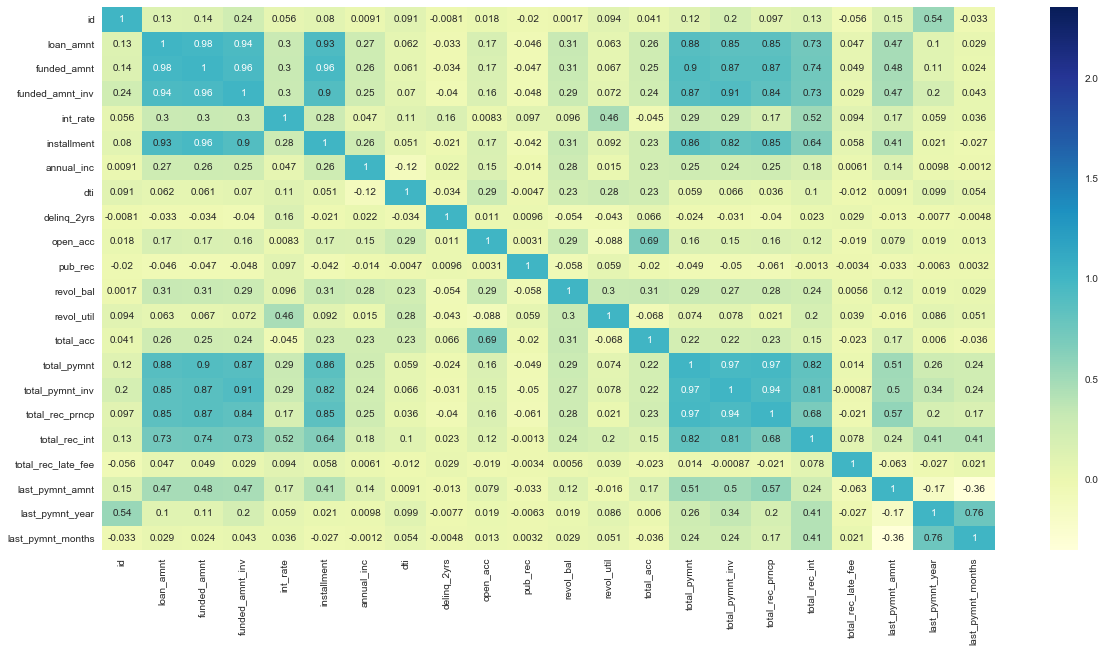

In [ ]:
plt.figure(figsize=(20, 10))
cols = loan_correlation.columns.values

sns.heatmap(loan_correlation,xticklabels=cols,yticklabels=cols,annot= True,center=1,cmap="YlGnBu")


### From the above correlation values and heatmap: 
1. The columns 'loan_amnt','funded_amnt' & 'funded_amnt_inv' are positively correlated with correlation > 0.9.
2. The columns 'total_pymnt','total_pymnt_inv','total_rec_int' & 'total_rec_prncp' are positively correlated with correlation > 0.8.
<BR>Hence we can choose one column for the above sets. i.e'funded_amnt', 'total_pymnt' and discard the other columns.

In [ ]:
print(len(list(loan)))
loan.drop(['total_rec_prncp','total_pymnt',
           'total_pymnt_inv','total_rec_late_fee',
           'total_rec_int','total_acc',
           'funded_amnt_inv','last_pymnt_year',
           'loan_amnt','pub_rec','open_acc'],axis=1,inplace=True)
print(len(list(loan)))

46
35


## Correlation heatmap after discarding positively correlated columns.

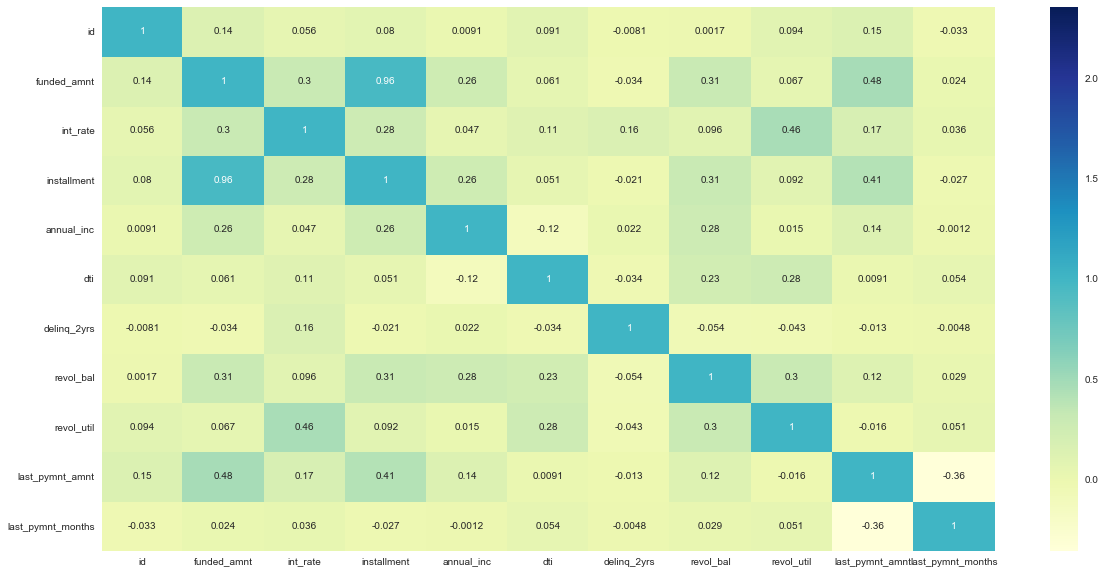

In [ ]:
loan_correlation = loan.select_dtypes(exclude=["object"]).corr()
loan_correlation

# sns.set(font_scale=1.4)
plt.figure(figsize=(20, 10))
cols = loan_correlation.columns.values

sns.heatmap(loan_correlation,xticklabels=cols,yticklabels=cols,annot= True,center=1,cmap="YlGnBu")

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

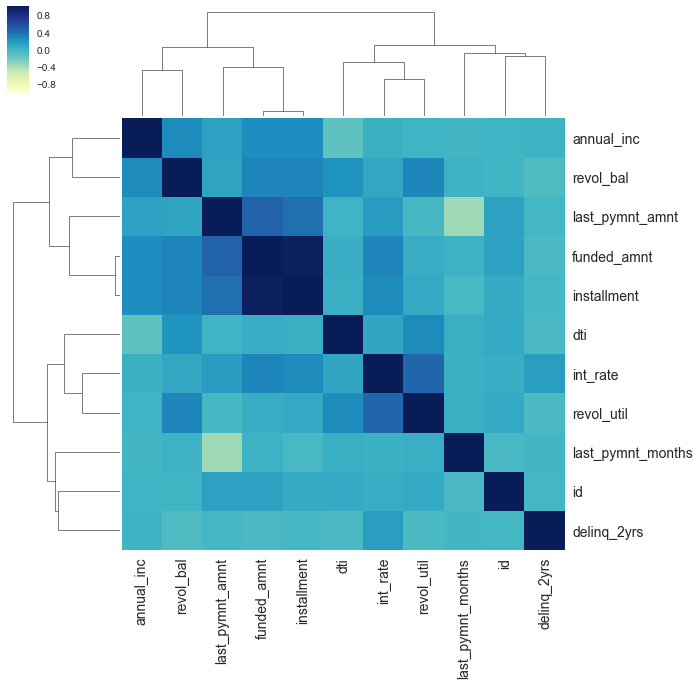

In [ ]:
plt.figure(figsize=(15, 15))
fig = sns.clustermap(loan_correlation, cmap="YlGnBu", method="ward", robust=True)
plt.setp(fig.ax_heatmap.get_yticklabels(), rotation=0, fontsize='14')
plt.setp(fig.ax_heatmap.get_xticklabels(), fontsize='14')

In [ ]:
loan.loc[loan['loan_status'] == 'Fully Paid', 'loan_status_int'] = 0
loan.loc[loan['loan_status'] == 'Charged Off', 'loan_status_int'] = 1

In [ ]:
corr = loan.corr()['loan_status_int'].sort_values()
print('Most Positive Correlations:\n', corr.tail(10))
print('\nMost Negative Correlations:\n', corr.head(10))

Most Positive Correlations:
 annual_inc        -0.037333
revol_bal          0.008531
delinq_2yrs        0.018202
installment        0.031295
id                 0.041666
dti                0.044005
funded_amnt        0.061283
revol_util         0.099897
int_rate           0.211183
loan_status_int    1.000000
Name: loan_status_int, dtype: float64

Most Negative Correlations:
 last_pymnt_months   -0.269560
last_pymnt_amnt     -0.220101
annual_inc          -0.037333
revol_bal            0.008531
delinq_2yrs          0.018202
installment          0.031295
id                   0.041666
dti                  0.044005
funded_amnt          0.061283
revol_util           0.099897
Name: loan_status_int, dtype: float64


Go to: [Top](#top) <BR>
Go to: [4.a Correlation Matrix](#corr_matrix) <BR>
Go to: [4.c Bivariate analysis of Categorical Analysis](#bivariate_categorical)
<a id='bivariate_numerical'/> 

### 4.b Bivariate analysis of Numerical Analysis

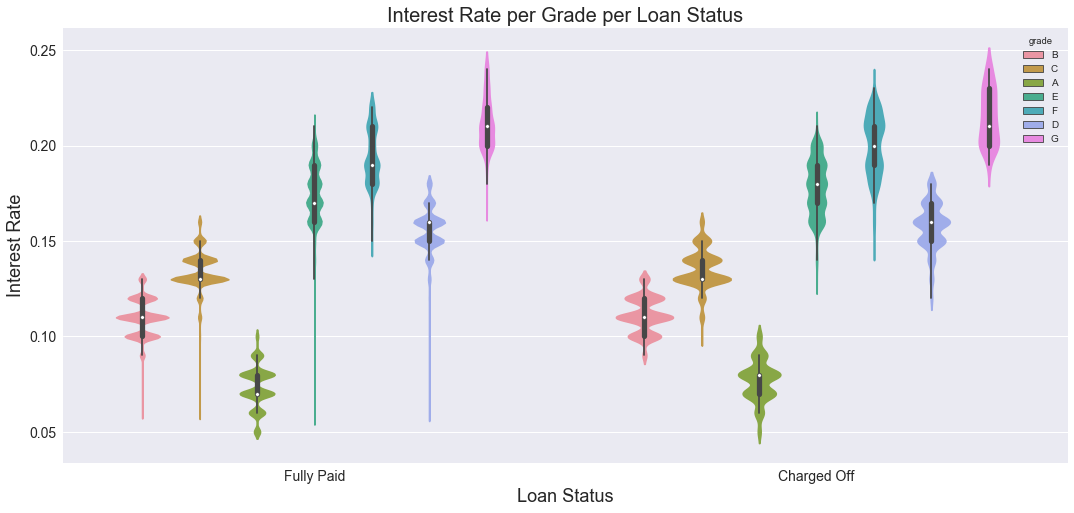

In [ ]:
fig = plt.figure(figsize=(18,8))
plot = sns.violinplot(x="loan_status",y="int_rate",data=loan, hue="grade")
setLabels(plot, 'Loan Status', 'Interest Rate', 'Interest Rate per Grade per Loan Status')

**Both Fully Paid & Charged Off have similar kind of interest rates by grades**

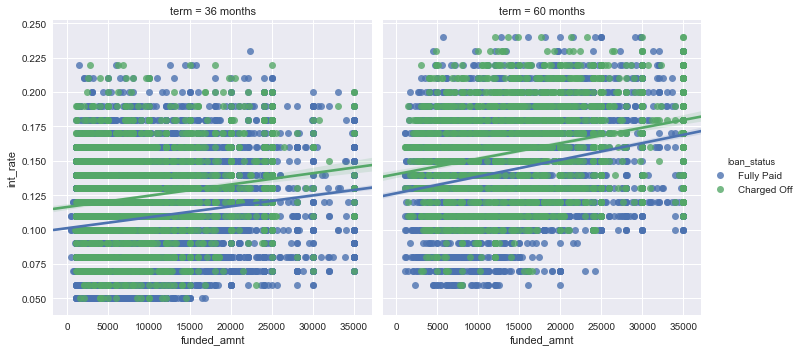

In [ ]:
plt.figure(figsize=[20,5])
sns.lmplot(x='funded_amnt',y='int_rate',data=loan,hue='loan_status',col='term')

#### Customers who have defaulted(charged off) have a slightly higher interest rate. This could be a decision taken by banks due to their risk characteristcs or credit score.

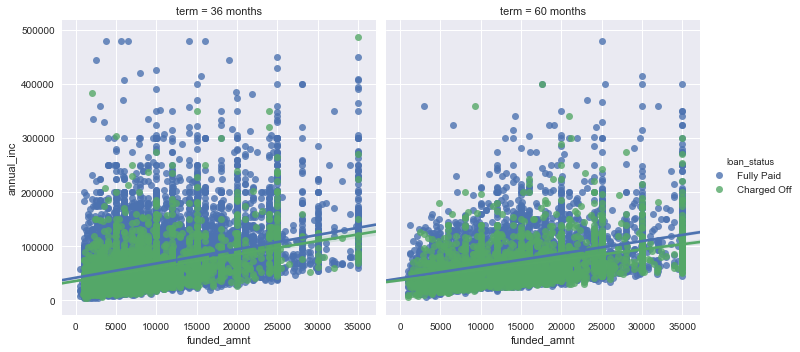

In [ ]:
plt.figure(figsize=[20,5])
sns.lmplot(x='funded_amnt',y='annual_inc',data=loan[loan['annual_inc']<500000],hue='loan_status',col='term')

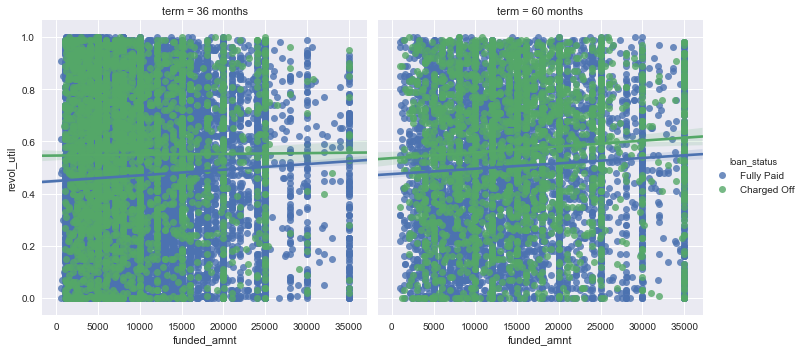

In [ ]:
plt.figure(figsize=[20,5])
sns.lmplot(x='funded_amnt',y='revol_util',data=loan,hue='loan_status',col='term')

#### revol_util and funded_amnt don't seem to highly correlated however, this shows that charged off customers have a higher revol_util than fully paid ones.

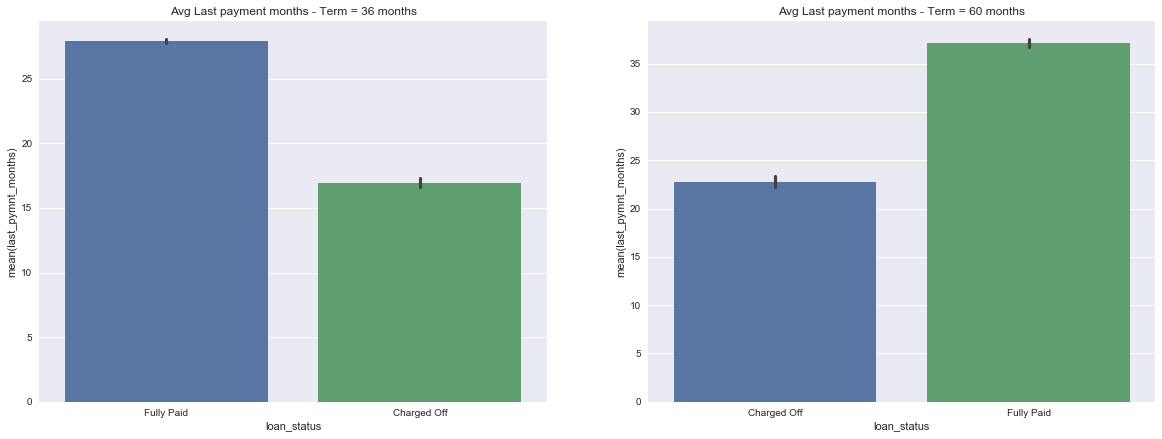

In [ ]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.barplot(x='loan_status',y='last_pymnt_months',data=loan[loan['term']=='36 months'],ax=ax1)
sns.barplot(x='loan_status',y='last_pymnt_months',data=loan[loan['term']=='60 months'],ax=ax2)
ax1.set_title('Avg Last payment months - Term = 36 months')
ax2.set_title('Avg Last payment months - Term = 60 months')

**Last Payment month for charged off loans is around**
* 16th month for 36 months term
* 23rd month for 60 months term
### Therefore, on an average customers default at the 16th month mark for a 36 month loan and 23rd month for a 60 month loan

Go to: [Top](#top) <BR>
Go to: [Bivariate Analysis](#bivariate_analysis) <BR>
Go to: [4.a Correlation Matrix](#corr_matrix) <BR>
Go to: [4.b Bivariate Analysis of numeric variables](#bivariate_numerical)
<a id ='bivariate_categorical'/>

## 4.c Bivariate analysis on categorical variables

### Extract all records with highly influential grades E, F, G to verify whether these grades contribute to higher % of charged off across all loan amount ranges and income categories

In [ ]:
loan_grade_G = loan[loan.grade == 'G']
loan_grade_F = loan[loan.grade == 'F']
loan_grade_E = loan[loan.grade == 'E']
charge_off_rates_G = loan_grade_G.groupby('income_category')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
charge_off_rates_F = loan_grade_F.groupby('income_category')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
charge_off_rates_E = loan_grade_E.groupby('income_category')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

In [ ]:
round(((len(loan_grade_G[loan_grade_G.loan_status == 'Charged Off'])/len(loan_grade_G))*100),2)

33.11

In [ ]:
round(((len(loan_grade_F[loan_grade_F.loan_status == 'Charged Off'])/len(loan_grade_F))*100),2)

32.5

In [ ]:
round(((len(loan_grade_E[loan_grade_E.loan_status == 'Charged Off'])/len(loan_grade_E))*100),2)

26.46

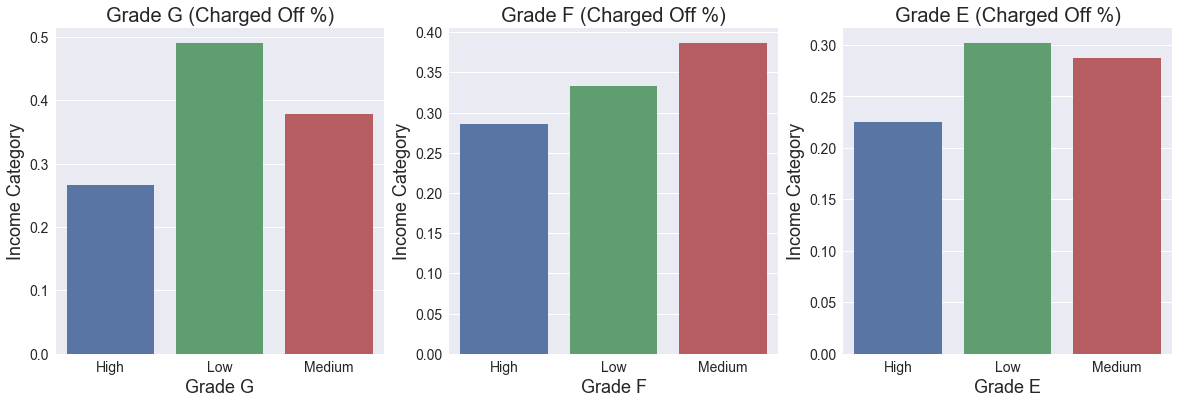

In [ ]:
plt.figure(figsize = [20,6])
plt.subplot(1,3,1)
plot1 = sns.barplot(x=charge_off_rates_G.index, y=charge_off_rates_G.values)
# plt.title("Grade G (Charged Off %)")
setLabels(plot1, 'Grade G', 'Income Category', 'Grade G (Charged Off %)')

plt.subplot(1,3,2)
plot2= sns.barplot(x=charge_off_rates_F.index, y=charge_off_rates_F.values)
# plt.title("Grade F (Charged Off %)")
setLabels(plot2, 'Grade F', 'Income Category', 'Grade F (Charged Off %)')

plt.subplot(1,3,3)
plot3 = sns.barplot(x=charge_off_rates_E.index, y=charge_off_rates_E.values)
# plt.title("Grade E (Charged Off %)")
setLabels(plot3, 'Grade E', 'Income Category', 'Grade E (Charged Off %)')

### Conclusion: High percentage of customers with bad grades have defaulted irrespective of their income levels. Even though, customers with low income have defaulted more in number than their high income counterparts, yet these plots prove the causation for bad grades (E, F, G)

In [ ]:
charge_off_rates_GL = loan_grade_G.groupby('loan_amnt_ranges')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
charge_off_rates_FL = loan_grade_F.groupby('loan_amnt_ranges')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
charge_off_rates_EL = loan_grade_E.groupby('loan_amnt_ranges')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

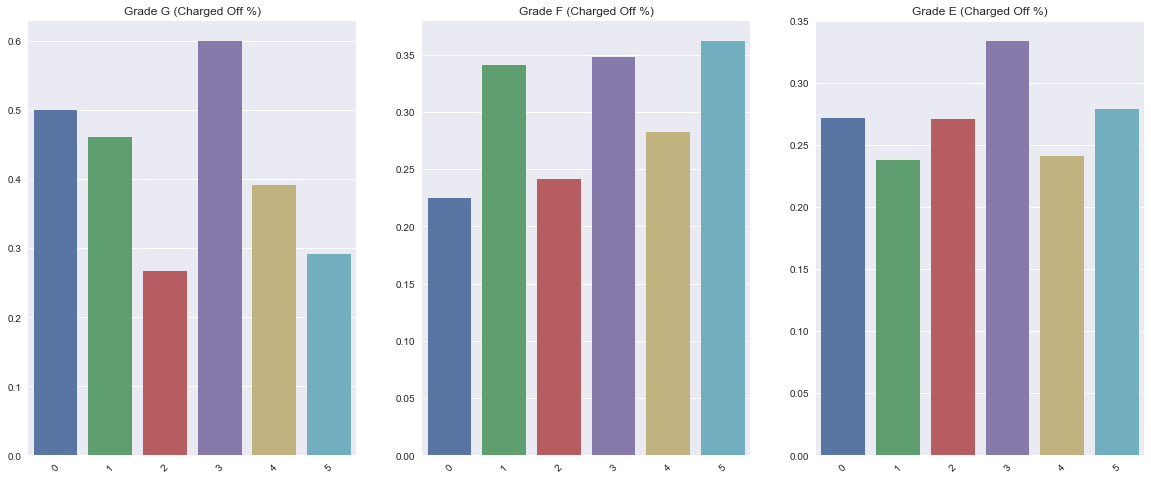

In [ ]:
plt.figure(figsize = [20,8])
plt.subplot(1,3,1)
sns.barplot(x=charge_off_rates_GL.reset_index().index, y=charge_off_rates_GL.values)
plt.title("Grade G (Charged Off %)")
plt.xticks(rotation = 45)

plt.subplot(1,3,2)
sns.barplot(x=charge_off_rates_FL.reset_index().index, y=charge_off_rates_FL.values)
plt.title("Grade F (Charged Off %)")
plt.xticks(rotation = 45)

plt.subplot(1,3,3)
sns.barplot(x=charge_off_rates_EL.reset_index().index, y=charge_off_rates_EL.values)
plt.title("Grade E (Charged Off %)")
plt.xticks(rotation = 45)
# include labels

### Conclusion: High percentage of customers with bad grades have defaulted irrespective of the loan amount. Despite the difference of % of customers defaulting across different loan amount ranges yet these plots prove the causation for bad grades (E, F, G)

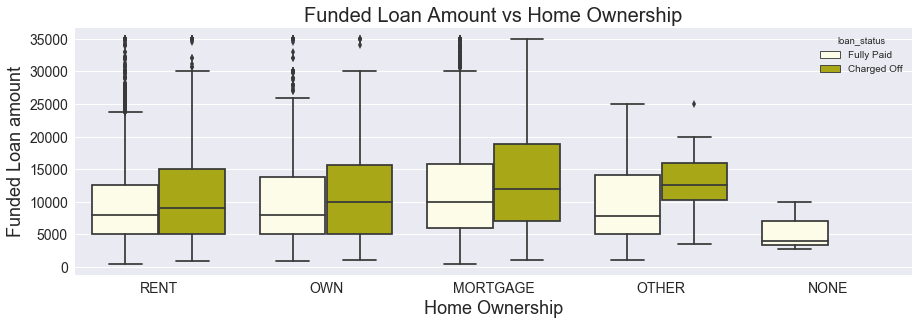

In [ ]:
fig = plt.figure(figsize=(15,10))

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='funded_amnt', hue='loan_status',
               data=loan, color='y')
setLabels(g, 'Home Ownership', 'Funded Loan amount', 'Funded Loan Amount vs Home Ownership')
# plt.title('Home Ownership vs Funded Amount')

 **<u>Conclusion:<u> The Home Ownership types RENT, OWN & MORTGAGE are higher on the Charged Off loans when the loan amounts funded lies between USD.5000 to USD.20000.** <BR>However, this is a minor influencer on the loan status as the funded amount is low for the Charged Off. Need to look into other influencer w.r.t loan funded amount.

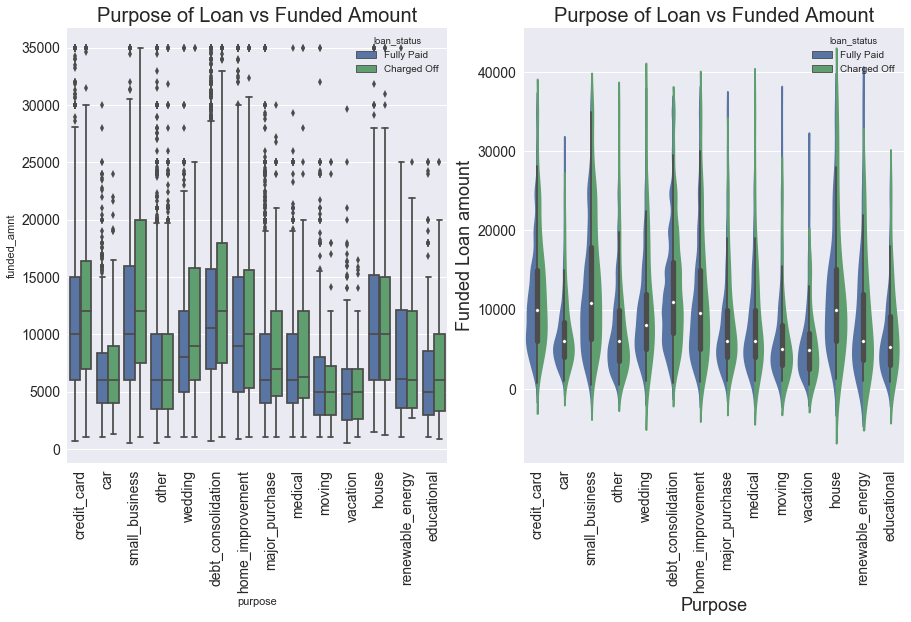

In [ ]:
fig, (ax1,ax2)= plt.subplots(nrows=1, ncols=2, figsize=(15,8))
plot1 = sns.boxplot(data =loan, x='purpose', y='funded_amnt', hue ='loan_status',ax=ax1)

setLabels(plot1, 'Purpose', 'Funded Loan amount', 'Purpose of Loan vs Funded Amount')
plt.sca(ax1)
plt.xticks(rotation=90, fontsize=14)
# plt.yticks(fontsize=14)

plot2 = sns.violinplot(x="purpose", y="funded_amnt", data=loan, hue='loan_status',split=True,ax=ax2 )
plt.sca(ax2)
plt.xticks(rotation=90, fontsize =14)
# plt.yticks(fontsize=14)
setLabels(plot2, 'Purpose', 'Funded Loan amount', 'Purpose of Loan vs Funded Amount')

 **<u>Conclusion:<u> The loans taken from the small business owners tend to have higher risk of defaulting. We will see the impact of the annual income vs the small business in the plots below [click here](#ann_inc_vs_funded_amnt)** 

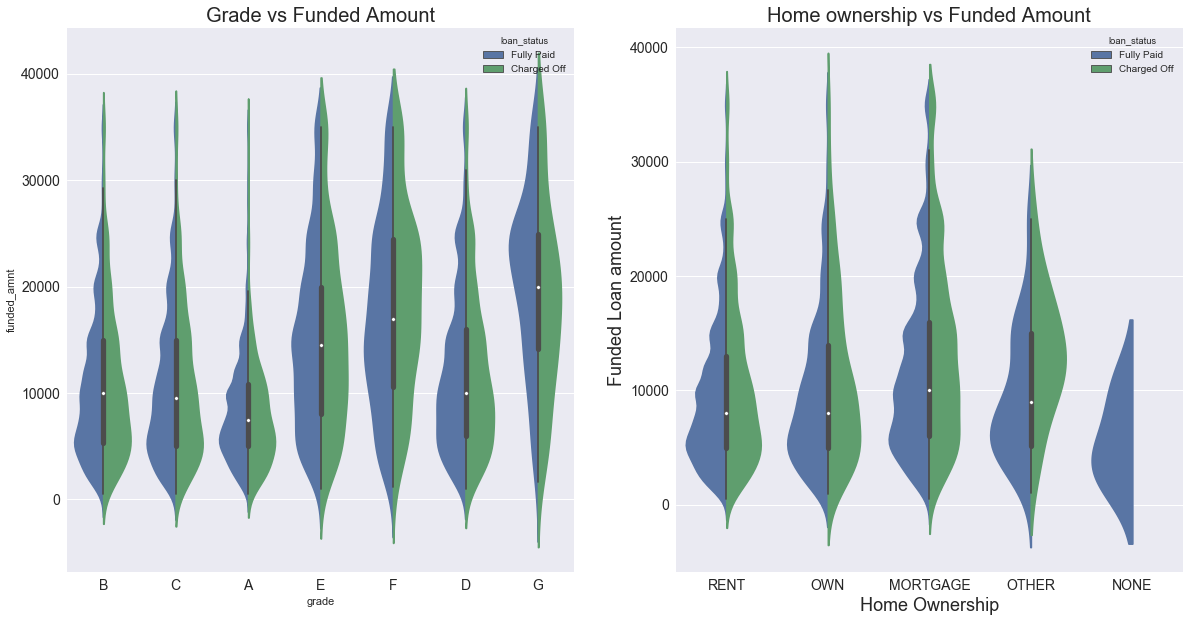

In [ ]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(20,10))
plot1 = sns.violinplot(x="grade", y="funded_amnt", data=loan, hue='loan_status',split=True,ax=ax1 )
plot2 = sns.violinplot(x="home_ownership", y="funded_amnt", data=loan, hue='loan_status',split=True,ax=ax2 )
setLabels(plot1, 'Grade', 'Funded Loan amount', 'Grade vs Funded Amount')
setLabels(plot2, 'Home Ownership', 'Funded Loan amount', 'Home ownership vs Funded Amount')

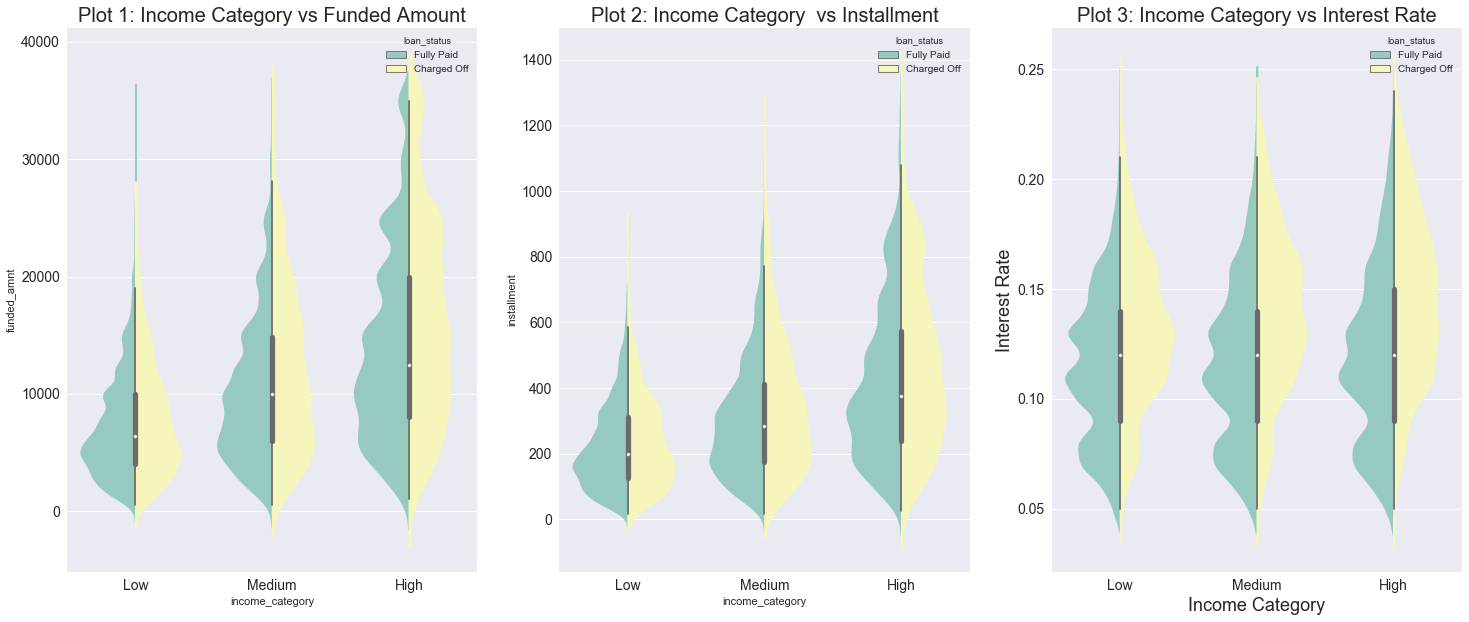

In [ ]:
fig, ((ax1, ax2, ax4))= plt.subplots(nrows=1, ncols=3, figsize=(25,10))

p1 = sns.violinplot(x="income_category", y="funded_amnt", data=loan, hue='loan_status', ax=ax1,split=True,palette="Set3" )
setLabels(p1, 'Income Category', 'Funded Loan amount', 'Plot 1: Income Category vs Funded Amount')

p2 = sns.violinplot(x="income_category", y="installment", data=loan,hue='loan_status', ax=ax2,split=True,palette="Set3")
setLabels(p2, 'Income Category', 'Installment', 'Plot 2: Income Category  vs Installment')
# p3 = sns.violinplot(x="income_category", y="dti", data=loan, hue='loan_status', ax=ax3,split=True,palette="Set3")
# setLabels(p3, 'Income Category', 'dti', 'Plot 3: Income Gategory vs Debt-To-Income Ratio')
p4 = sns.violinplot(x="income_category", y="int_rate", data=loan, hue='loan_status', ax=ax4,split=True,palette="Set3")
setLabels(p4, 'Income Category', 'Interest Rate', 'Plot 3: Income Category vs Interest Rate')


#### Conclusion;
Plot 1. As the funded loan amount increases, the high income group of Charged Off tend to increase. <BR>
Plot 2. Lower the Installments, the medium and high income group have more chances of defaulting the loan. <BR>
Plot 3: The dti ration across income remains the same for the Fully paid and charged off loans. <BR>
Plot 4: Higher the interest rates, there are changes of loans getting defaulted across income category.    
    

<a id='ann_inc_vs_funded_amnt' />

### purpose (purpose of loan) vs income_category & loan_amnt_ranges

In [ ]:
loan_smallbus = loan[loan.purpose == 'small_business']
charge_off_rates_smbi = loan_smallbus.groupby('income_category')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
charge_off_rates_smbl = loan_smallbus.groupby('loan_amnt_ranges')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

In [ ]:
round(((len(loan_smallbus[loan_smallbus.loan_status == 'Charged Off'])/len(loan_smallbus))*100),2)

26.67

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

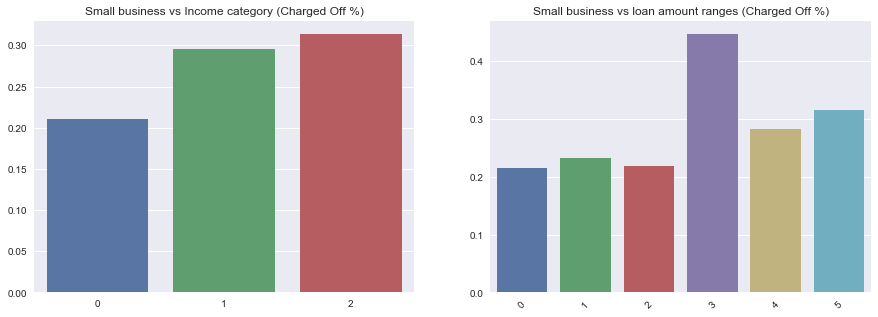

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sns.barplot(x=charge_off_rates_smbi.reset_index().index, y=charge_off_rates_smbi.values)
plt.title("Small business vs Income category (Charged Off %)")
# plt.figure(figsize=[25,5])
plt.subplot(1,2,2)
sns.barplot(x=charge_off_rates_smbl.reset_index().index, y=charge_off_rates_smbl.values)
plt.title("Small business vs loan amount ranges (Charged Off %)")
plt.xticks(rotation = 45)

### Conclusion: Loans taken for the purpose of "small business" have generally defaulted on high percentage irrespective of income_category and loan amount ranges. These plots prove the causation for "small businesses" performing bad in terms of loan repayment.

Go to: [Top](#top)<BR>
Go to: [Bivariate analysis](#bivariate_analysis)<BR>
Go to: [Bivariate analysis of Categorical variables](#bivariate_categorical)

***
<a id='final_conclusion' />

## Final Conclusions

In [ ]:
def getAvgChargedOffPerForVariable(varName, df, loanStatus):
    t = getPercData(varName, df)
    t = t[(t['loan_status'] == loanStatus)]
    t_avg_perc = round(t['id'].median(), 3)
    return [varName, t_avg_perc]

In [ ]:
loan_data_string_columns = list(loan.select_dtypes(['object','category']))
loan_data_string_columns.remove('loan_status')
loan_data_string_columns.remove('total_rec_late_fee_range')
loan_data_string_columns.remove('emp_title')

In [ ]:
avgPerDf = pd.DataFrame(columns=['Variable', 'Representative Charged Off Percentage'])
for column in loan_data_string_columns:
    avgPerDf = avgPerDf.append(pd.Series(getAvgChargedOffPerForVariable(column, loan, 'Charged Off'), index=['Variable', 'Representative Charged Off Percentage']), ignore_index=True)

avgPerDf = avgPerDf.sort_values(by='Representative Charged Off Percentage', ascending=False)
avgPerDf

Variable  Representative Charged Off Percentage
2               sub_grade                                  0.225
1                   grade                                  0.216
0                    term                                  0.179
4                 purpose                                  0.151
9         int_rate_ranges                                  0.151
12             dti_ranges                                  0.146
16        income_category                                  0.146
3          home_ownership                                  0.146
11      annual_inc_ranges                                  0.145
5                zip_code                                  0.143
13        open_acc_ranges                                  0.141
14      revol_util_ranges                                  0.141
6              addr_state                                  0.138
15                 region                                  0.136
7   earliest_cr_line_year                                  0.135
10     installment_ranges                                  0.134
8        loan_amnt_ranges                                  0.130

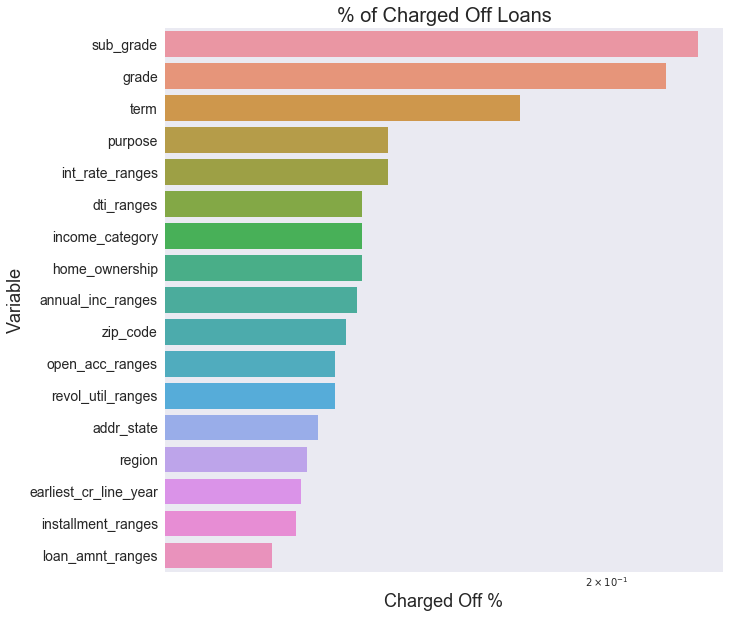

In [ ]:
plt.figure(figsize=(10,10))
fully_paid_vs_charged_off_loans = sns.barplot(x='Representative Charged Off Percentage', y='Variable', data=avgPerDf, log=True)
plt.xlabel('Charged Off %', fontsize=18)
plt.ylabel('Variable', fontsize=18)
fully_paid_vs_charged_off_loans.set_title('% of Charged Off Loans', fontsize=20)
plt.setp(fully_paid_vs_charged_off_loans.get_xticklabels(), fontsize=14)
plt.setp(fully_paid_vs_charged_off_loans.get_yticklabels(), fontsize=14)
plt.show()

In [ ]:
loan_data_float_columns = list(loan.select_dtypes(['float64','int64']))
loan_data_float_columns.remove('id')
print(loan_data_float_columns)
def chargedOffAvgRatioToTotalAvg(varName, df):
    data_grp_avg_loan_status1 = df.pivot_table(values=varName, index='loan_status', aggfunc='median').reset_index()
    charged_off_loan_amnt_avg1 = data_grp_avg_loan_status1[data_grp_avg_loan_status1['loan_status'] == 'Charged Off'][varName]
    fully_paid_loan_amnt_avg1 = data_grp_avg_loan_status1[data_grp_avg_loan_status1['loan_status'] == 'Fully Paid'][varName]
    totalAvg = df[varName].median()   
    if totalAvg > 0:
        ratio = charged_off_loan_amnt_avg1/totalAvg
        return [varName, round(float(charged_off_loan_amnt_avg1), 2), round(float(totalAvg), 2), round(float(fully_paid_loan_amnt_avg1), 2), round(float(ratio), 2)]

avgPerDf1 = pd.DataFrame(columns=['Variable', 'Representative Charged Off', 'Representative Total', 'Representative Fully Paid', 'Charged Off Ratio'])
for column in loan_data_float_columns:
    chargedOffAvgRatioToTotalAvg_list = chargedOffAvgRatioToTotalAvg(column, loan)
    if chargedOffAvgRatioToTotalAvg_list != None:
        avgPerDf1 = avgPerDf1.append(pd.Series(chargedOffAvgRatioToTotalAvg_list, index=['Variable', 'Representative Charged Off', 'Representative Total', 'Representative Fully Paid', 'Charged Off Ratio']), ignore_index=True)

avgPerDf1 = avgPerDf1.sort_values(by='Charged Off Ratio', ascending=False)
avgPerDf1

['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_bal', 'revol_util', 'last_pymnt_amnt', 'last_pymnt_months', 'loan_status_int']


Variable  Representative Charged Off  Representative Total  \
6         revol_util                        0.59                  0.49   
1           int_rate                        0.14                  0.12   
2        installment                      298.67                280.23   
4                dti                       14.32                 13.39   
5          revol_bal                     9421.00               8852.50   
0        funded_amnt                    10000.00               9600.00   
3         annual_inc                    54000.00              60000.00   
8  last_pymnt_months                       17.97                 31.05   
7    last_pymnt_amnt                      245.47                581.25   

   Representative Fully Paid  Charged Off Ratio  
6                       0.48               1.20  
1                       0.11               1.17  
2                     277.73               1.07  
4                      13.21               1.07  
5                    8773.00               1.06  
0                    9450.00               1.04  
3                   60000.00               0.90  
8                      34.00               0.58  
7                     877.02               0.42

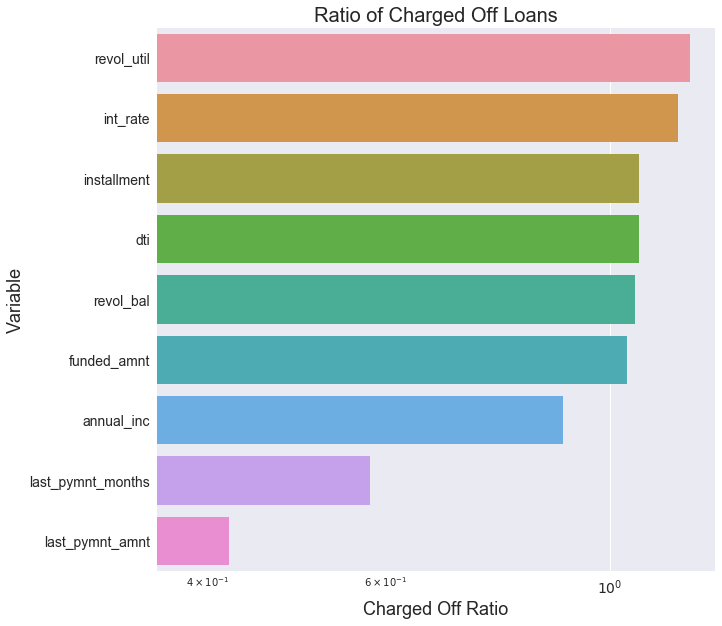

In [ ]:
plt.figure(figsize=(10,10))
fully_paid_vs_charged_off_loans = sns.barplot(x='Charged Off Ratio', y='Variable', data=avgPerDf1, log=True)
plt.xlabel('Charged Off Ratio', fontsize=18)
plt.ylabel('Variable', fontsize=18)
fully_paid_vs_charged_off_loans.set_title('Ratio of Charged Off Loans', fontsize=20)
plt.setp(fully_paid_vs_charged_off_loans.get_xticklabels(), fontsize=14)
plt.setp(fully_paid_vs_charged_off_loans.get_yticklabels(), fontsize=14)
plt.show()

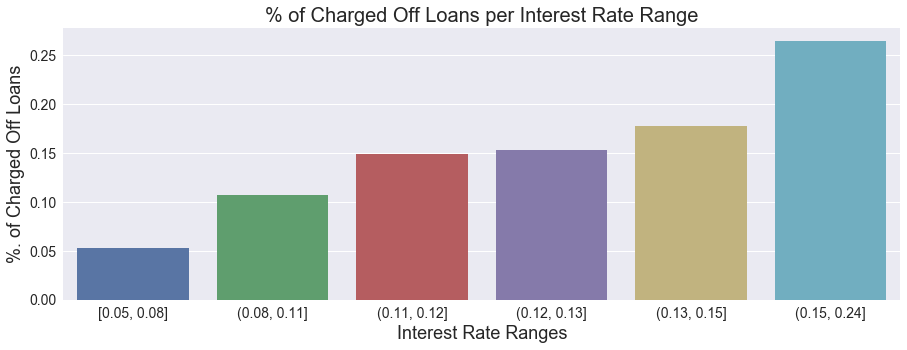

In [ ]:
plt.figure(figsize=(15, 5))
createPercPlot('int_rate_ranges', 'Interest Rate Ranges', '%. of Charged Off Loans', '% of Charged Off Loans per Interest Rate Range')

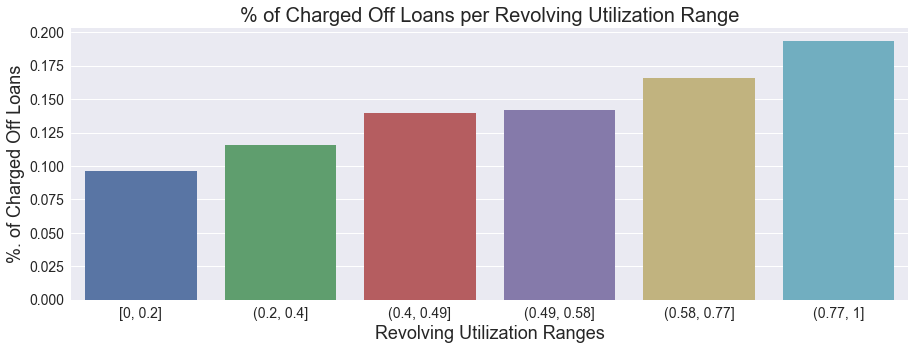

In [ ]:
plt.figure(figsize=(15, 5))
createPercPlot('revol_util_ranges', 'Revolving Utilization Ranges', '%. of Charged Off Loans', '% of Charged Off Loans per Revolving Utilization Range')

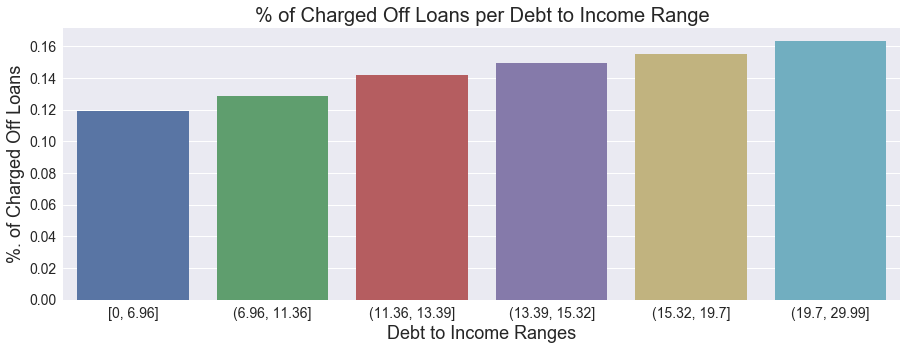

In [ ]:
plt.figure(figsize=(15, 5))
createPercPlot('dti_ranges', 'Debt to Income Ranges', '%. of Charged Off Loans', '% of Charged Off Loans per Debt to Income Range')

Go to: [Top](#top)